In [0]:
from PIL import Image

In [0]:
# это для удобства сабмитить на  KAGGLE
import os
os.environ['KAGGLE_USERNAME'] = "gavril2" # username from the json file
os.environ['KAGGLE_KEY'] = "52beb4d3fdafcbe08b3f9d042871f6ac" # key from the json file

In [10]:
# Restart runtime before running this code block if new PIL installed
import torch
print("PyTorch version: ", torch.__version__)
print("CUDA version: ", torch.version.cuda)
print("cuDNN version is: ", torch.backends.cudnn.version())
print('Device:', torch.device('cuda:0'))

import PIL
print('Python PIL version:', PIL.PILLOW_VERSION)

PyTorch version:  1.3.1
CUDA version:  10.1.243
cuDNN version is:  7603
Device: cuda:0
Python PIL version: 6.2.2


In [11]:
import numpy as np
import pandas as pd
import torch

import PIL
print(PIL.PILLOW_VERSION)

#file paths
#/kaggle/input/simpsons4/train
#/kaggle/input/simpsons4/testset/testset

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

6.2.2
CUDA is available!  Training on GPU ...


In [0]:
import pickle
import numpy as np
from skimage import io
import random

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [0]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [0]:
DATA_MODES = ['train', 'val', 'test']
RESCALE_SIZE = 224
DEVICE = torch.device("cuda")

# Dataset construction

Пример аугментаций, поменяйте на те, которые считаете нужными и добавьте код в свой класс Dataset'a.
Самая популярная библиотека для аугментаций на kaggle — **Albumentations**.

https://github.com/albumentations-team/albumentations/blob/master/notebooks/showcase.ipynb

In [0]:
from albumentations.pytorch import ToTensor
import albumentations as A
# Define the augmentation pipeline
augmentation_pipeline = A.Compose(
    [
        A.HorizontalFlip(p = 0.5), # apply horizontal flip to 50% of images
        A.OneOf(
            [
                # Добавим некторых преобразовний картинок
                A.RandomContrast(), # apply random contrast
                A.RandomGamma(), # apply random gamma
                A.RandomBrightness(),
                A.ShiftScaleRotate(),
               
                A.ElasticTransform(
                    alpha = 120,
                    sigma = 120 * 0.05,
                    alpha_affine = 120 * 0.03
                ),
                A.GridDistortion(),
                A.OpticalDistortion(
                    distort_limit = 2,
                    shift_limit = 0.5
                ),
                A.GaussNoise(),# apply random brightness
            ],
            p = 0.5
        ),
        
        A.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]),
        
        ToTensor() # convert the image to PyTorch tensor
    ],
    p = 1
)
class SimpsonsDataset(Dataset):
  def __init__(self, files, mode, augmentations = None):
    super().__init__()
    self.files = files
    self.mode = mode
    self.augmentations = augmentations
    #self.rnd_transform = augmentation_pipeline 
    #transforms.RandomChoice([
               # transforms.RandomHorizontalFlip(p=0.66),
                #transforms.RandomVerticalFlip(p=0.66),
                ##transforms.RandomRotation(180),
   # transforms.RandomGamma(),])

    if self.mode not in DATA_MODES:
      print(f'wrong mode: {self.mode}')
      raise NameError

    self.len_ = len(self.files)
    self.label_encoder = LabelEncoder()

    if self.mode != 'test':
      self.labels = [path.parent.name for path in self.files]
      self.label_encoder.fit(self.labels)

      with open('label_encoder.pkl', 'wb') as le_dump:
        pickle.dump(self.label_encoder, le_dump)

  def __len__(self):
    return self.len_

  def load_sample(self, file):
    image = Image.open(file)
    image.load()
    return image

  def __getitem__(self, index):
    transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])                                
    ])

    x = self.load_sample(self.files[index])
    x = self._prepare_sample(x)
    

    
    if self.mode == 'test':
      x = transform(x)
  
      return x
    else:
      augumented = self.augmentations(image = x)  
      label = self.labels[index]
      label_id = self.label_encoder.transform([label])
      y = label_id.item()
      return augumented['image'], y

  def _prepare_sample(self, image):
    image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
    return np.array(image)




In [0]:
# Подключи Гугл-диск
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [0]:
# Разарахивируем
!unzip -q /content/gdrive/My\ Drive/simpsons/data/simpsons4.zip

In [0]:
TRAIN_DIR = Path('train/simpsons_dataset')

TEST_DIR = Path('testset/testset')
SAVE_DIR = Path('models/')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

Желательно, чтобы схема валидации повторяла схему разбития public/private. В данном соревновании это 30/70. 

In [0]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.3,stratify=train_val_labels)

In [0]:
val_dataset = SimpsonsDataset(val_files, mode='val')
train_dataset = SimpsonsDataset(train_files, mode='train',augmentations = augmentation_pipeline)


In [0]:
all_dataset = SimpsonsDataset(train_val_files, mode='train',augmentations = augmentation_pipeline)

Ned Flanders


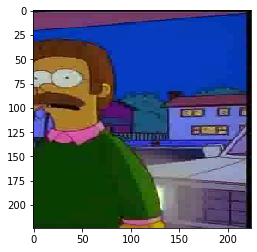

In [0]:
imshow(train_dataset[0][0])
print(" ".join(map(lambda x: x.capitalize(),\
                train_dataset.label_encoder.inverse_transform([train_dataset[0][1]])[0].split('_'))))

# Exploring the data

In [0]:
def imshow(img, title=None, plt_ax=plt, default=False):
  img = img.numpy().transpose((1, 2, 0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  img = std * img + mean
  img = np.clip(img, 0, 1)
  plt_ax.imshow(img)
  if title is not None:
    plt_ax.set_title(title)
  plt_ax.grid(False)

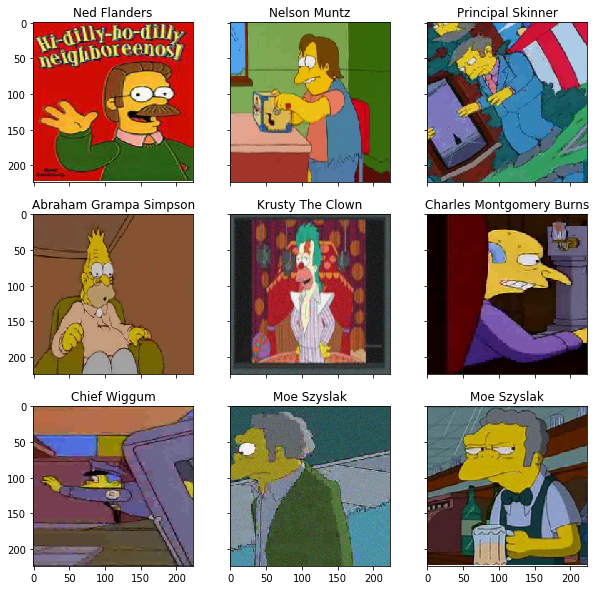

In [0]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(10,10), sharex=True, sharey=True)

for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    #print(random_characters)
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    #print(img_label)
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

# Попорбуем сеть из Baseline

Соберем нашу модель, сейчас она простая — несколько сверток и FC (fully conected) слоев. Накинуть скор можно за счет изменения параметров, конфигурации самой сети, подключения предобученной модели (например, ResNet).

In [0]:
class ConvModel(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU()
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU()
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.BatchNorm2d(96),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU()
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=96, out_channels=164, kernel_size=3),
            nn.BatchNorm2d(164),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU()
        )
        self.fc1 = nn.Sequential(
            nn.Linear(5 * 5 * 164, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
        )
        self.fc2 = nn.Sequential(
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU()
        )        
        self.out = nn.Linear(1024, n_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = x.view(-1, 5 * 5 * 164)
        x = self.fc1(x)
        x = self.fc2(x)

        logits = self.out(x)
        return logits

Функции для обучения и оценки модели. Тут можно поиграться с learning rate, добавить для него scheduler, который будет его варьировать.

In [0]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc
  
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc
  
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
      
        #Здесь можно добавить схему изменения learning rate
        
        opt = torch.optim.Adam(model.parameters())

        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [0]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

Создадим модель, проверим, что в ней те слои, которые нам нужны.

In [0]:
n_classes = len(np.unique(train_val_labels))
model = ConvModel(n_classes).to(DEVICE)
print(model)

ConvModel(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(8, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): ReLU()
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): ReLU()
  )
  (conv4): Sequential(
    (0): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

# Train

Запустим модель. Обратите внимание, что результат (и score) может немного отличаться в зависимости от batch_size.
Тут можно поменять на большее количество эпох. Но не переобучись!

In [0]:
history = train(train_dataset, val_dataset, model=model, epochs=10, batch_size=32)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 1.6859628040050392


epoch:  10%|█         | 1/10 [02:21<21:14, 141.65s/it]


Epoch 001 train_loss: 1.6860     val_loss 1.2479 train_acc 0.5340 val_acc 0.6511
loss 1.0713521125885617


epoch:  20%|██        | 2/10 [04:42<18:52, 141.55s/it]


Epoch 002 train_loss: 1.0714     val_loss 0.9568 train_acc 0.6967 val_acc 0.7293
loss 0.7403950837417844


epoch:  30%|███       | 3/10 [07:03<16:28, 141.17s/it]


Epoch 003 train_loss: 0.7404     val_loss 0.8180 train_acc 0.7884 val_acc 0.7758
loss 0.5638125975132151


epoch:  40%|████      | 4/10 [09:23<14:04, 140.82s/it]


Epoch 004 train_loss: 0.5638     val_loss 0.6951 train_acc 0.8376 val_acc 0.8145
loss 0.43527523546217084


epoch:  50%|█████     | 5/10 [11:43<11:42, 140.58s/it]


Epoch 005 train_loss: 0.4353     val_loss 0.6104 train_acc 0.8710 val_acc 0.8374
loss 0.3460748452526192


epoch:  60%|██████    | 6/10 [14:04<09:22, 140.68s/it]


Epoch 006 train_loss: 0.3461     val_loss 0.5989 train_acc 0.8966 val_acc 0.8454
loss 0.2723274908419364


epoch:  70%|███████   | 7/10 [16:24<07:01, 140.52s/it]


Epoch 007 train_loss: 0.2723     val_loss 0.6291 train_acc 0.9221 val_acc 0.8476
loss 0.24490396245029658


epoch:  80%|████████  | 8/10 [18:44<04:40, 140.42s/it]


Epoch 008 train_loss: 0.2449     val_loss 0.6748 train_acc 0.9308 val_acc 0.8393
loss 0.21670841304184282


epoch:  90%|█████████ | 9/10 [21:05<02:20, 140.57s/it]


Epoch 009 train_loss: 0.2167     val_loss 0.6199 train_acc 0.9370 val_acc 0.8592
loss 0.18505692841837384


epoch: 100%|██████████| 10/10 [23:26<00:00, 140.71s/it]


Epoch 010 train_loss: 0.1851     val_loss 0.6331 train_acc 0.9458 val_acc 0.8549


In [0]:
loss, acc, val_loss, val_acc = zip(*history)

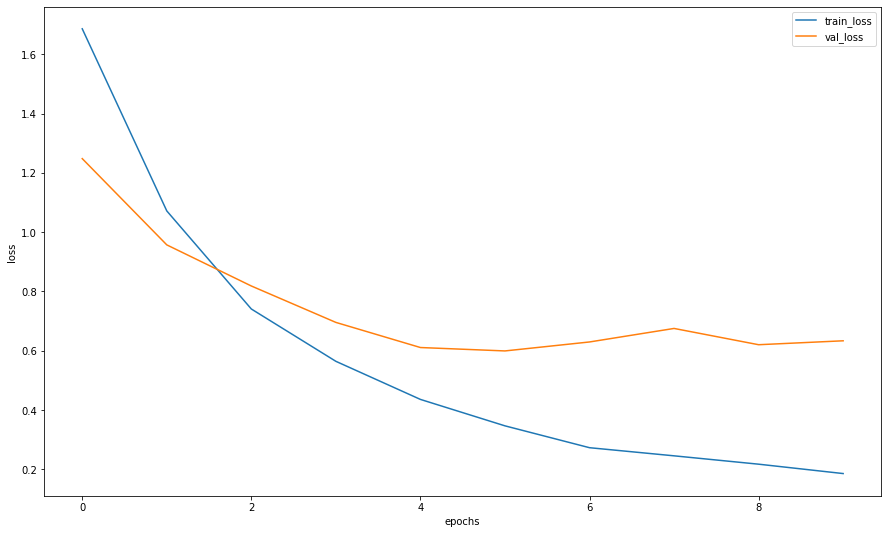

In [0]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

# Submission

In [0]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model, test_loader)

preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [0]:
submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [0]:
submit.to_csv('submission.csv', index=False)

In [0]:
#!kaggle competitions submit -c simpsons4 -f 'submission.csv' -m "Message"

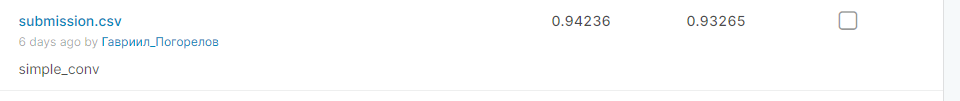

In [0]:
#Неплохо, но изменение парметров, как и колчисества эпох, не дает особого прироста в f1
# Вот лучший результат, что удалось получить
from IPython.core.display import Image, display
display(Image('/content/simple_CNN.PNG', width=1000, unconfined=True))

In [0]:
Fine


# Finetuning

### VGG16

In [0]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [0]:
model_name = "vgg"
num_classes=n_classes
feature_extract = 1
from torchvision import datasets, models, transforms

In [0]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size



In [0]:
# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

In [0]:
def train(train_files, val_files, model, epochs, batch_size, auto_save=True):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"
    # Точность модели на предудущим шаге
    train_acc = 0
    # Лучшая точность модели
    max_acc = -1
    with tqdm(desc="epoch", total=epochs) as pbar_outer:
      
        #Здесь можно добавить схему изменения learning rate
        
        opt = torch.optim.Adam(model.parameters())

        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            if auto_save and max_acc < train_acc:
                # Сохраняем лучшую модель
                torch.save(model, SAVE_DIR.joinpath("model_acc"+str(train_acc)+".pth"))
                max_acc = train_acc
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
    #if auto_save and train_acc < max_acc:
      #  print("Загружаем модель с train_acc = ", max_acc)
       #model = torch.load(SAVE_DIR.joinpath("model.pth"))
        #model.eval()      
    return history

####  Попробуем для началача дообучить только последний слой

In [0]:



# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
import torch.optim as optim
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
#optimizer_ft=optim.AdamW(params_to_update, lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01, amsgrad=False)
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 classifier.6.weight
	 classifier.6.bias


In [0]:
history = train(train_dataset, val_dataset, model=model_ft, epochs=10, batch_size=256)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 2.330940319760736


epoch:  10%|█         | 1/10 [03:24<30:38, 204.25s/it]


Epoch 001 train_loss: 2.3309     val_loss 1.7722 train_acc 0.3915 val_acc 0.5522
loss 1.5765454452013241


epoch:  20%|██        | 2/10 [06:48<27:13, 204.23s/it]


Epoch 002 train_loss: 1.5765     val_loss 1.5000 train_acc 0.5874 val_acc 0.6018
loss 1.378072475318021


epoch:  30%|███       | 3/10 [10:12<23:49, 204.20s/it]


Epoch 003 train_loss: 1.3781     val_loss 1.3991 train_acc 0.6304 val_acc 0.6244
loss 1.237458055307212


epoch:  40%|████      | 4/10 [13:36<20:24, 204.04s/it]


Epoch 004 train_loss: 1.2375     val_loss 1.3082 train_acc 0.6685 val_acc 0.6439
loss 1.155923303789485


epoch:  50%|█████     | 5/10 [16:58<16:57, 203.59s/it]


Epoch 005 train_loss: 1.1559     val_loss 1.2663 train_acc 0.6861 val_acc 0.6530
loss 1.102511065621136


epoch:  60%|██████    | 6/10 [20:22<13:34, 203.60s/it]


Epoch 006 train_loss: 1.1025     val_loss 1.2404 train_acc 0.7018 val_acc 0.6634
loss 1.0400662186901894


epoch:  70%|███████   | 7/10 [23:45<10:09, 203.31s/it]


Epoch 007 train_loss: 1.0401     val_loss 1.2067 train_acc 0.7156 val_acc 0.6748
loss 0.9774019994573333


epoch:  80%|████████  | 8/10 [27:07<06:45, 202.96s/it]


Epoch 008 train_loss: 0.9774     val_loss 1.1818 train_acc 0.7321 val_acc 0.6758
loss 0.9411858304290651


epoch:  90%|█████████ | 9/10 [30:30<03:23, 203.08s/it]


Epoch 009 train_loss: 0.9412     val_loss 1.1546 train_acc 0.7397 val_acc 0.6865
loss 0.9109856213293556


epoch: 100%|██████████| 10/10 [33:53<00:00, 203.19s/it]


Epoch 010 train_loss: 0.9110     val_loss 1.1347 train_acc 0.7484 val_acc 0.6876


In [0]:
loss, acc, val_loss, val_acc = zip(*history)


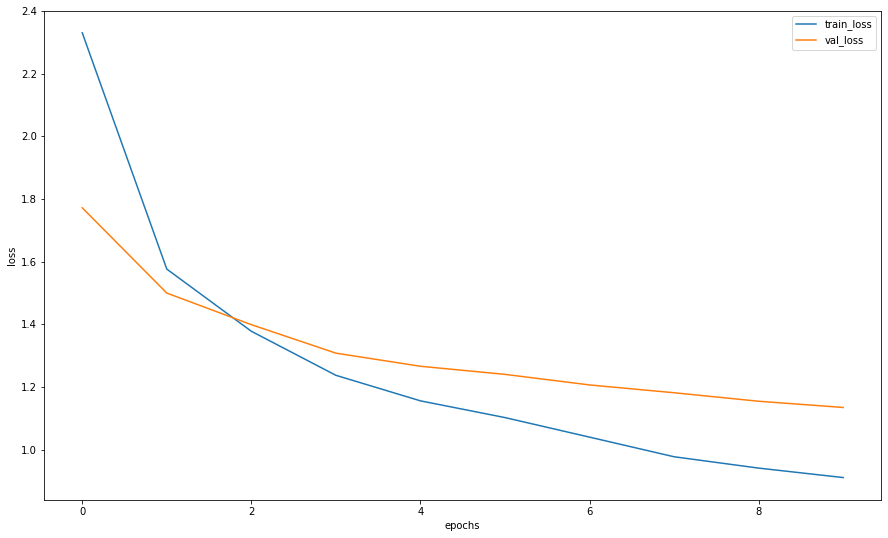

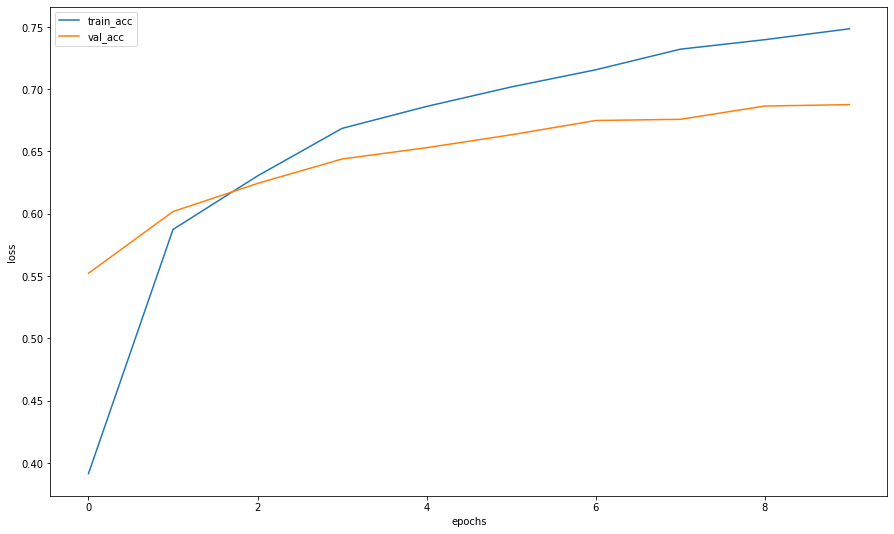

In [0]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")

plt.figure(figsize=(15, 9))
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

#### Видно -сетка учится но, крайне медленно.
#### Попробуем другую модель

 ### RESNET

In [0]:
model_name = "resnet"
num_classes=n_classes
feature_extract = 1
from torchvision import datasets, models, transforms

In [0]:
# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:02<00:00, 21.9MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### также попорбуем дообучить послдений слой

In [0]:

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
import torch.optim as optim
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
#optimizer_ft=optim.AdamW(params_to_update, lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01, amsgrad=False)
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 fc.weight
	 fc.bias


In [0]:
history = train(train_dataset, val_dataset, model=model_ft, epochs=10, batch_size=256)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 2.7807157369780393


epoch:  10%|█         | 1/10 [02:17<20:35, 137.32s/it]


Epoch 001 train_loss: 2.7807     val_loss 2.2817 train_acc 0.2647 val_acc 0.4777
loss 2.0184196281260633


epoch:  20%|██        | 2/10 [04:33<18:16, 137.10s/it]


Epoch 002 train_loss: 2.0184     val_loss 1.8328 train_acc 0.5434 val_acc 0.5855
loss 1.6624941365316785


epoch:  30%|███       | 3/10 [06:50<15:57, 136.83s/it]


Epoch 003 train_loss: 1.6625     val_loss 1.5987 train_acc 0.6145 val_acc 0.6131
loss 1.4767912594782144


epoch:  40%|████      | 4/10 [09:05<13:38, 136.39s/it]


Epoch 004 train_loss: 1.4768     val_loss 1.4545 train_acc 0.6434 val_acc 0.6449
loss 1.3523043138146327


epoch:  50%|█████     | 5/10 [11:22<11:22, 136.46s/it]


Epoch 005 train_loss: 1.3523     val_loss 1.3753 train_acc 0.6655 val_acc 0.6487
loss 1.263030305613611


epoch:  60%|██████    | 6/10 [13:37<09:04, 136.20s/it]


Epoch 006 train_loss: 1.2630     val_loss 1.3024 train_acc 0.6834 val_acc 0.6634
loss 1.193987530603723


epoch:  70%|███████   | 7/10 [15:55<06:49, 136.57s/it]


Epoch 007 train_loss: 1.1940     val_loss 1.2468 train_acc 0.6937 val_acc 0.6750
loss 1.1532113579347387


epoch:  80%|████████  | 8/10 [18:13<04:34, 137.04s/it]


Epoch 008 train_loss: 1.1532     val_loss 1.2202 train_acc 0.7024 val_acc 0.6803
loss 1.105624070804062


epoch:  90%|█████████ | 9/10 [20:31<02:17, 137.51s/it]


Epoch 009 train_loss: 1.1056     val_loss 1.1892 train_acc 0.7134 val_acc 0.6823
loss 1.0695164098329921


epoch: 100%|██████████| 10/10 [22:49<00:00, 137.65s/it]


Epoch 010 train_loss: 1.0695     val_loss 1.1469 train_acc 0.7181 val_acc 0.7010


In [0]:
loss, acc, val_loss, val_acc = zip(*history)

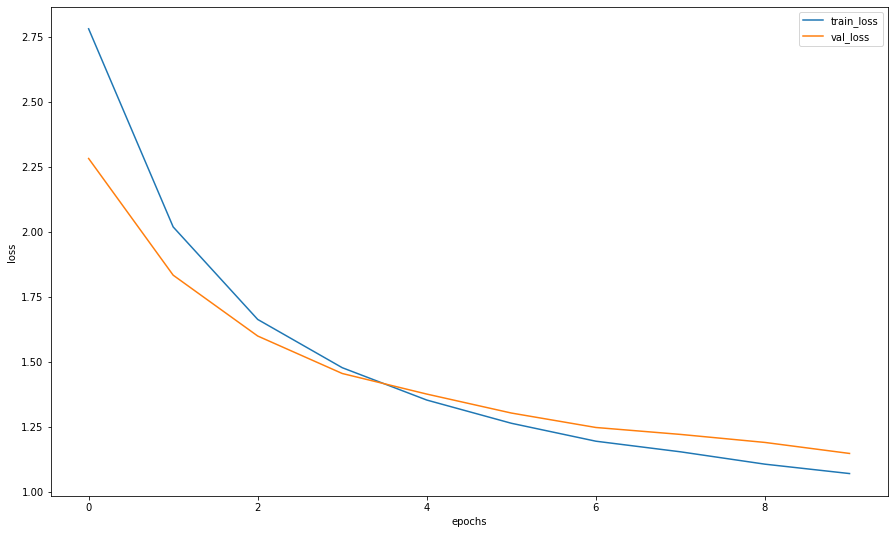

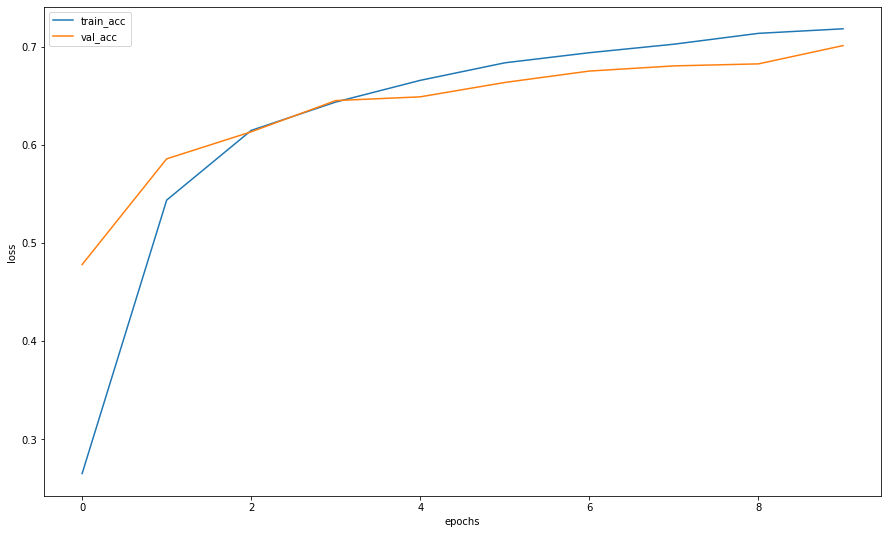

In [0]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")

plt.figure(figsize=(15, 9))
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

### RESNET дает большую точность

### Поробуем с другим оптимизатором

In [0]:
# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [0]:

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
import torch.optim as optim
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft=optim.AdamW(params_to_update, lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01, amsgrad=False)
#optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 fc.weight
	 fc.bias


In [0]:
history = train(train_dataset, val_dataset, model=model_ft, epochs=10, batch_size=256)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 2.7915291596637


epoch:  10%|█         | 1/10 [02:19<20:58, 139.80s/it]


Epoch 001 train_loss: 2.7915     val_loss 2.2961 train_acc 0.2655 val_acc 0.4573
loss 2.0133528491299217


epoch:  20%|██        | 2/10 [04:37<18:33, 139.18s/it]


Epoch 002 train_loss: 2.0134     val_loss 1.8368 train_acc 0.5376 val_acc 0.5702
loss 1.6661442912235884


epoch:  30%|███       | 3/10 [06:56<16:14, 139.22s/it]


Epoch 003 train_loss: 1.6661     val_loss 1.6060 train_acc 0.6060 val_acc 0.6024
loss 1.473489159505489


epoch:  40%|████      | 4/10 [09:15<13:54, 139.16s/it]


Epoch 004 train_loss: 1.4735     val_loss 1.4514 train_acc 0.6415 val_acc 0.6470
loss 1.3454743896028267


epoch:  50%|█████     | 5/10 [11:34<11:35, 139.10s/it]


Epoch 005 train_loss: 1.3455     val_loss 1.3770 train_acc 0.6680 val_acc 0.6481
loss 1.257626205989869


epoch:  60%|██████    | 6/10 [13:53<09:16, 139.01s/it]


Epoch 006 train_loss: 1.2576     val_loss 1.3051 train_acc 0.6859 val_acc 0.6613
loss 1.1980990914568546


epoch:  70%|███████   | 7/10 [16:11<06:56, 138.78s/it]


Epoch 007 train_loss: 1.1981     val_loss 1.2479 train_acc 0.6930 val_acc 0.6758
loss 1.1496004742387618


epoch:  80%|████████  | 8/10 [18:30<04:37, 138.73s/it]


Epoch 008 train_loss: 1.1496     val_loss 1.2097 train_acc 0.7014 val_acc 0.6860
loss 1.1100958099155664


epoch:  90%|█████████ | 9/10 [20:49<02:18, 138.72s/it]


Epoch 009 train_loss: 1.1101     val_loss 1.1760 train_acc 0.7082 val_acc 0.6890
loss 1.0638450616570876


epoch: 100%|██████████| 10/10 [23:08<00:00, 138.94s/it]


Epoch 010 train_loss: 1.0638     val_loss 1.1590 train_acc 0.7197 val_acc 0.6976


In [0]:
loss, acc, val_loss, val_acc = zip(*history)

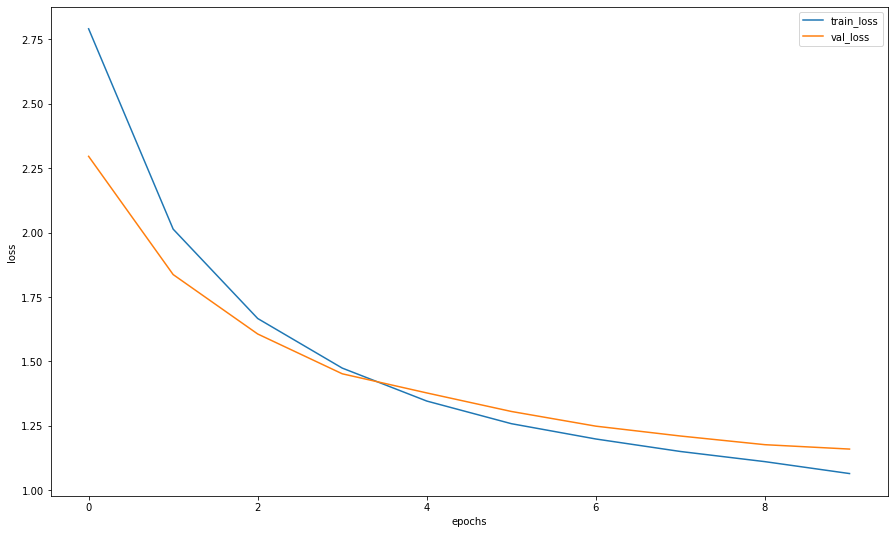

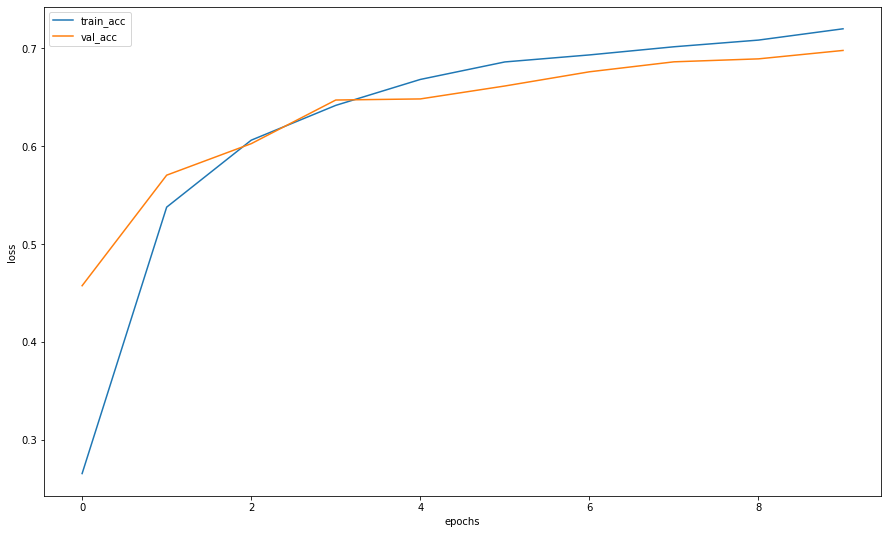

In [0]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")

plt.figure(figsize=(15, 9))
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

#### Особых изменией мы не увидели

## Попробуем ход конем- полность переобучить RESNET

In [0]:
history = train(train_dataset, val_dataset, model=model_ft, epochs=200, batch_size=256)

In [0]:
model_name = "resnet"
num_classes=n_classes
feature_extract = 1
from torchvision import datasets, models, transforms

In [0]:
# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)

In [0]:
history = train(train_dataset, val_dataset, model=model_ft, epochs=200, batch_size=256)


epoch:   0%|          | 0/200 [00:00<?, ?it/s]/home/gavril/.local/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ResNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/gavril/.local/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/gavril/.local/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type BatchNorm2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/gavril/.local/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ReLU. It won't be checked for correctness upon loading.

loss 0.2507669907156041


epoch:   0%|          | 1/200 [01:40<5:32:22, 100.21s/it]


Epoch 001 train_loss: 0.2508     val_loss 0.2423 train_acc 0.9339 val_acc 0.9379
loss 0.17088747136907545


epoch:   1%|          | 2/200 [03:16<5:27:04, 99.12s/it] 


Epoch 002 train_loss: 0.1709     val_loss 0.2787 train_acc 0.9542 val_acc 0.9256
loss 0.16870297661683814


epoch:   2%|▏         | 3/200 [04:52<5:22:09, 98.12s/it]


Epoch 003 train_loss: 0.1687     val_loss 0.1677 train_acc 0.9533 val_acc 0.9540
loss 0.13349248981818335


epoch:   2%|▏         | 4/200 [06:28<5:18:37, 97.54s/it]


Epoch 004 train_loss: 0.1335     val_loss 0.2023 train_acc 0.9630 val_acc 0.9468
loss 0.1315629146182154


epoch:   2%|▎         | 5/200 [08:04<5:15:14, 97.00s/it]


Epoch 005 train_loss: 0.1316     val_loss 0.2539 train_acc 0.9625 val_acc 0.9347
loss 0.17264360233064416


epoch:   3%|▎         | 6/200 [09:40<5:12:46, 96.74s/it]


Epoch 006 train_loss: 0.1726     val_loss 0.2057 train_acc 0.9524 val_acc 0.9441
loss 0.12634560723809313


epoch:   4%|▎         | 7/200 [11:16<5:10:19, 96.47s/it]


Epoch 007 train_loss: 0.1263     val_loss 0.2591 train_acc 0.9653 val_acc 0.9381
loss 0.12947069062266442


epoch:   4%|▍         | 8/200 [12:52<5:08:23, 96.37s/it]


Epoch 008 train_loss: 0.1295     val_loss 0.1934 train_acc 0.9634 val_acc 0.9533
loss 0.11875988219495455


epoch:   4%|▍         | 9/200 [14:28<5:06:46, 96.37s/it]


Epoch 009 train_loss: 0.1188     val_loss 0.2587 train_acc 0.9651 val_acc 0.9361
loss 0.0901534447310069


epoch:   5%|▌         | 10/200 [16:05<5:05:02, 96.33s/it]


Epoch 010 train_loss: 0.0902     val_loss 0.2039 train_acc 0.9740 val_acc 0.9495
loss 0.0952079548668082


epoch:   6%|▌         | 11/200 [17:40<5:02:21, 95.99s/it]


Epoch 011 train_loss: 0.0952     val_loss 0.2113 train_acc 0.9747 val_acc 0.9476
loss 0.09691672537104389


epoch:   6%|▌         | 12/200 [19:16<5:00:55, 96.04s/it]


Epoch 012 train_loss: 0.0969     val_loss 0.2277 train_acc 0.9731 val_acc 0.9444
loss 0.08959855148001172


epoch:   6%|▋         | 13/200 [20:52<4:59:27, 96.08s/it]


Epoch 013 train_loss: 0.0896     val_loss 0.2272 train_acc 0.9758 val_acc 0.9452
loss 0.10463749323812356


epoch:   7%|▋         | 14/200 [22:28<4:57:23, 95.93s/it]


Epoch 014 train_loss: 0.1046     val_loss 0.2199 train_acc 0.9696 val_acc 0.9460
loss 0.07745983639280357


epoch:   8%|▊         | 15/200 [24:03<4:55:04, 95.70s/it]


Epoch 015 train_loss: 0.0775     val_loss 0.2612 train_acc 0.9787 val_acc 0.9369
loss 0.09121240072330135


epoch:   8%|▊         | 16/200 [25:40<4:54:16, 95.96s/it]


Epoch 016 train_loss: 0.0912     val_loss 0.2264 train_acc 0.9741 val_acc 0.9439
loss 0.09248501574522089


epoch:   8%|▊         | 17/200 [27:21<4:57:41, 97.60s/it]


Epoch 017 train_loss: 0.0925     val_loss 0.2167 train_acc 0.9745 val_acc 0.9494
loss 0.06955168113272109


epoch:   9%|▉         | 18/200 [29:00<4:56:56, 97.89s/it]


Epoch 018 train_loss: 0.0696     val_loss 0.2212 train_acc 0.9794 val_acc 0.9505
loss 0.07104893858021886


epoch:  10%|▉         | 19/200 [30:35<4:53:26, 97.27s/it]


Epoch 019 train_loss: 0.0710     val_loss 0.2021 train_acc 0.9814 val_acc 0.9510
loss 0.06636979621131778


epoch:  10%|█         | 20/200 [32:12<4:51:18, 97.10s/it]


Epoch 020 train_loss: 0.0664     val_loss 0.2272 train_acc 0.9828 val_acc 0.9438
loss 0.06485872498568775


epoch:  10%|█         | 21/200 [33:48<4:48:14, 96.62s/it]


Epoch 021 train_loss: 0.0649     val_loss 0.2242 train_acc 0.9825 val_acc 0.9492
loss 0.06967614852219957


epoch:  11%|█         | 22/200 [35:29<4:50:31, 97.93s/it]


Epoch 022 train_loss: 0.0697     val_loss 0.2299 train_acc 0.9808 val_acc 0.9449
loss 0.0747316439539697


epoch:  12%|█▏        | 23/200 [37:07<4:49:05, 98.00s/it]


Epoch 023 train_loss: 0.0747     val_loss 0.2335 train_acc 0.9791 val_acc 0.9457
loss 0.06534625113667347


epoch:  12%|█▏        | 24/200 [38:44<4:46:59, 97.84s/it]


Epoch 024 train_loss: 0.0653     val_loss 0.2837 train_acc 0.9812 val_acc 0.9384
loss 0.06605469009611523


epoch:  12%|█▎        | 25/200 [40:20<4:43:34, 97.22s/it]


Epoch 025 train_loss: 0.0661     val_loss 0.2536 train_acc 0.9810 val_acc 0.9459
loss 0.07341864781991529


epoch:  13%|█▎        | 26/200 [41:56<4:40:57, 96.88s/it]


Epoch 026 train_loss: 0.0734     val_loss 0.2393 train_acc 0.9788 val_acc 0.9443
loss 0.06221536335168679


epoch:  14%|█▎        | 27/200 [43:33<4:39:07, 96.80s/it]


Epoch 027 train_loss: 0.0622     val_loss 0.2328 train_acc 0.9838 val_acc 0.9449
loss 0.07109492087208809


epoch:  14%|█▍        | 28/200 [45:09<4:37:25, 96.77s/it]


Epoch 028 train_loss: 0.0711     val_loss 0.2681 train_acc 0.9790 val_acc 0.9371
loss 0.05917743392488767


epoch:  14%|█▍        | 29/200 [46:46<4:35:33, 96.69s/it]


Epoch 029 train_loss: 0.0592     val_loss 0.2476 train_acc 0.9833 val_acc 0.9435
loss 0.06410716587139512


epoch:  15%|█▌        | 30/200 [48:22<4:33:44, 96.62s/it]


Epoch 030 train_loss: 0.0641     val_loss 0.2130 train_acc 0.9832 val_acc 0.9518
loss 0.06794572621126317


epoch:  16%|█▌        | 31/200 [49:59<4:32:15, 96.66s/it]


Epoch 031 train_loss: 0.0679     val_loss 0.2399 train_acc 0.9816 val_acc 0.9494
loss 0.06444386691378748


epoch:  16%|█▌        | 32/200 [51:36<4:30:39, 96.66s/it]


Epoch 032 train_loss: 0.0644     val_loss 0.2290 train_acc 0.9813 val_acc 0.9473
loss 0.04905619615017615


epoch:  16%|█▋        | 33/200 [53:12<4:28:54, 96.62s/it]


Epoch 033 train_loss: 0.0491     val_loss 0.2039 train_acc 0.9867 val_acc 0.9580
loss 0.06628423377679313


epoch:  17%|█▋        | 34/200 [54:49<4:27:07, 96.55s/it]


Epoch 034 train_loss: 0.0663     val_loss 0.2267 train_acc 0.9822 val_acc 0.9479
loss 0.05854064011526199


epoch:  18%|█▊        | 35/200 [56:25<4:25:43, 96.63s/it]


Epoch 035 train_loss: 0.0585     val_loss 0.2551 train_acc 0.9835 val_acc 0.9406
loss 0.06035659447442523


epoch:  18%|█▊        | 36/200 [58:02<4:23:39, 96.46s/it]


Epoch 036 train_loss: 0.0604     val_loss 0.2676 train_acc 0.9833 val_acc 0.9409
loss 0.05439669679447887


epoch:  18%|█▊        | 37/200 [59:38<4:21:46, 96.36s/it]


Epoch 037 train_loss: 0.0544     val_loss 0.2205 train_acc 0.9850 val_acc 0.9529
loss 0.05637541502486109


epoch:  19%|█▉        | 38/200 [1:01:14<4:19:51, 96.24s/it]


Epoch 038 train_loss: 0.0564     val_loss 0.2546 train_acc 0.9848 val_acc 0.9482
loss 0.05848819568589516


epoch:  20%|█▉        | 39/200 [1:02:50<4:18:18, 96.26s/it]


Epoch 039 train_loss: 0.0585     val_loss 0.2172 train_acc 0.9839 val_acc 0.9486
loss 0.06191893107159458


epoch:  20%|██        | 40/200 [1:04:27<4:16:59, 96.37s/it]


Epoch 040 train_loss: 0.0619     val_loss 0.2647 train_acc 0.9825 val_acc 0.9470
loss 0.0668710182960966


epoch:  20%|██        | 41/200 [1:06:03<4:15:15, 96.32s/it]


Epoch 041 train_loss: 0.0669     val_loss 0.1954 train_acc 0.9814 val_acc 0.9532
loss 0.04487727036156736


epoch:  21%|██        | 42/200 [1:07:39<4:13:36, 96.31s/it]


Epoch 042 train_loss: 0.0449     val_loss 0.2016 train_acc 0.9892 val_acc 0.9557
loss 0.053999895922341855


epoch:  22%|██▏       | 43/200 [1:09:16<4:12:12, 96.38s/it]


Epoch 043 train_loss: 0.0540     val_loss 0.2303 train_acc 0.9851 val_acc 0.9508
loss 0.04912078832816095


epoch:  22%|██▏       | 44/200 [1:10:52<4:10:42, 96.43s/it]


Epoch 044 train_loss: 0.0491     val_loss 0.2367 train_acc 0.9866 val_acc 0.9481
loss 0.05876424718115067


epoch:  22%|██▎       | 45/200 [1:12:28<4:08:34, 96.22s/it]


Epoch 045 train_loss: 0.0588     val_loss 0.2339 train_acc 0.9835 val_acc 0.9476
loss 0.04133502831598507


epoch:  23%|██▎       | 46/200 [1:14:05<4:07:22, 96.38s/it]


Epoch 046 train_loss: 0.0413     val_loss 0.2642 train_acc 0.9886 val_acc 0.9494
loss 0.07115625576052269


epoch:  24%|██▎       | 47/200 [1:15:40<4:05:03, 96.10s/it]


Epoch 047 train_loss: 0.0712     val_loss 0.2394 train_acc 0.9822 val_acc 0.9455
loss 0.05718422289039018


epoch:  24%|██▍       | 48/200 [1:17:16<4:03:14, 96.02s/it]


Epoch 048 train_loss: 0.0572     val_loss 0.2505 train_acc 0.9838 val_acc 0.9425
loss 0.061004749735254056


epoch:  24%|██▍       | 49/200 [1:18:51<4:01:00, 95.77s/it]


Epoch 049 train_loss: 0.0610     val_loss 0.2622 train_acc 0.9843 val_acc 0.9428
loss 0.0521298158042591


epoch:  25%|██▌       | 50/200 [1:20:27<3:59:48, 95.92s/it]


Epoch 050 train_loss: 0.0521     val_loss 0.2505 train_acc 0.9864 val_acc 0.9465
loss 0.04487132965704345


epoch:  26%|██▌       | 51/200 [1:22:03<3:58:06, 95.88s/it]


Epoch 051 train_loss: 0.0449     val_loss 0.2650 train_acc 0.9876 val_acc 0.9412
loss 0.05166097698339275


epoch:  26%|██▌       | 52/200 [1:23:40<3:57:09, 96.15s/it]


Epoch 052 train_loss: 0.0517     val_loss 0.2353 train_acc 0.9854 val_acc 0.9476
loss 0.0487280209546674


epoch:  26%|██▋       | 53/200 [1:25:16<3:55:36, 96.16s/it]


Epoch 053 train_loss: 0.0487     val_loss 0.2390 train_acc 0.9871 val_acc 0.9508
loss 0.047561430612739534


epoch:  27%|██▋       | 54/200 [1:26:52<3:53:41, 96.04s/it]


Epoch 054 train_loss: 0.0476     val_loss 0.2303 train_acc 0.9857 val_acc 0.9454
loss 0.052942959137176


epoch:  28%|██▊       | 55/200 [1:28:28<3:52:04, 96.03s/it]


Epoch 055 train_loss: 0.0529     val_loss 0.2219 train_acc 0.9855 val_acc 0.9486
loss 0.046073487765376724


epoch:  28%|██▊       | 56/200 [1:30:04<3:50:34, 96.07s/it]


Epoch 056 train_loss: 0.0461     val_loss 0.2214 train_acc 0.9879 val_acc 0.9494
loss 0.04833170903851325


epoch:  28%|██▊       | 57/200 [1:31:40<3:49:04, 96.12s/it]


Epoch 057 train_loss: 0.0483     val_loss 0.2005 train_acc 0.9870 val_acc 0.9524
loss 0.05339913965893558


epoch:  29%|██▉       | 58/200 [1:33:19<3:49:03, 96.79s/it]


Epoch 058 train_loss: 0.0534     val_loss 0.2377 train_acc 0.9870 val_acc 0.9492
loss 0.04038999717061507


epoch:  30%|██▉       | 59/200 [1:34:56<3:47:32, 96.83s/it]


Epoch 059 train_loss: 0.0404     val_loss 0.2294 train_acc 0.9896 val_acc 0.9532
loss 0.04111273210610878


epoch:  30%|███       | 60/200 [1:36:32<3:45:52, 96.81s/it]


Epoch 060 train_loss: 0.0411     val_loss 0.2395 train_acc 0.9878 val_acc 0.9522
loss 0.04010200766213622


epoch:  30%|███       | 61/200 [1:38:09<3:44:21, 96.85s/it]


Epoch 061 train_loss: 0.0401     val_loss 0.2842 train_acc 0.9891 val_acc 0.9424
loss 0.0476926110300597


epoch:  31%|███       | 62/200 [1:39:49<3:44:25, 97.58s/it]


Epoch 062 train_loss: 0.0477     val_loss 0.2549 train_acc 0.9872 val_acc 0.9462
loss 0.0431966506027188


epoch:  32%|███▏      | 63/200 [1:41:29<3:44:48, 98.45s/it]


Epoch 063 train_loss: 0.0432     val_loss 0.2250 train_acc 0.9886 val_acc 0.9510
loss 0.041476165520119186


epoch:  32%|███▏      | 64/200 [1:43:06<3:42:28, 98.15s/it]


Epoch 064 train_loss: 0.0415     val_loss 0.2461 train_acc 0.9884 val_acc 0.9514
loss 0.03469194298055257


epoch:  32%|███▎      | 65/200 [1:44:44<3:40:44, 98.10s/it]


Epoch 065 train_loss: 0.0347     val_loss 0.2448 train_acc 0.9902 val_acc 0.9513
loss 0.04721474985144679


epoch:  33%|███▎      | 66/200 [1:46:21<3:37:50, 97.54s/it]


Epoch 066 train_loss: 0.0472     val_loss 0.2112 train_acc 0.9870 val_acc 0.9502
loss 0.04709521157399205


epoch:  34%|███▎      | 67/200 [1:47:57<3:35:09, 97.06s/it]


Epoch 067 train_loss: 0.0471     val_loss 0.3476 train_acc 0.9869 val_acc 0.9250
loss 0.06329613177118877


epoch:  34%|███▍      | 68/200 [1:49:33<3:33:02, 96.84s/it]


Epoch 068 train_loss: 0.0633     val_loss 0.2713 train_acc 0.9824 val_acc 0.9486
loss 0.05521029076307436


epoch:  34%|███▍      | 69/200 [1:51:09<3:31:05, 96.68s/it]


Epoch 069 train_loss: 0.0552     val_loss 0.2379 train_acc 0.9847 val_acc 0.9487
loss 0.03798391561411661


epoch:  35%|███▌      | 70/200 [1:52:46<3:29:18, 96.61s/it]


Epoch 070 train_loss: 0.0380     val_loss 0.2669 train_acc 0.9890 val_acc 0.9490
loss 0.038764736162648465


epoch:  36%|███▌      | 71/200 [1:54:21<3:27:05, 96.32s/it]


Epoch 071 train_loss: 0.0388     val_loss 0.2311 train_acc 0.9895 val_acc 0.9495
loss 0.04029729311586256


epoch:  36%|███▌      | 72/200 [1:55:57<3:25:09, 96.17s/it]


Epoch 072 train_loss: 0.0403     val_loss 0.2330 train_acc 0.9899 val_acc 0.9521
loss 0.03160158790823278


epoch:  36%|███▋      | 73/200 [1:57:33<3:23:21, 96.07s/it]


Epoch 073 train_loss: 0.0316     val_loss 0.2657 train_acc 0.9913 val_acc 0.9484
loss 0.03654953967206577


epoch:  37%|███▋      | 74/200 [1:59:09<3:21:55, 96.16s/it]


Epoch 074 train_loss: 0.0365     val_loss 0.2598 train_acc 0.9898 val_acc 0.9484
loss 0.037901443414736356


epoch:  38%|███▊      | 75/200 [2:00:45<3:20:15, 96.13s/it]


Epoch 075 train_loss: 0.0379     val_loss 0.2409 train_acc 0.9889 val_acc 0.9470
loss 0.04323396050481949


epoch:  38%|███▊      | 76/200 [2:02:21<3:18:21, 95.98s/it]


Epoch 076 train_loss: 0.0432     val_loss 0.2364 train_acc 0.9882 val_acc 0.9519
loss 0.0313640890416351


epoch:  38%|███▊      | 77/200 [2:03:58<3:17:18, 96.25s/it]


Epoch 077 train_loss: 0.0314     val_loss 0.2713 train_acc 0.9917 val_acc 0.9478
loss 0.03779342249231595


epoch:  39%|███▉      | 78/200 [2:05:34<3:15:19, 96.06s/it]


Epoch 078 train_loss: 0.0378     val_loss 0.3370 train_acc 0.9901 val_acc 0.9382
loss 0.0599368439837558


epoch:  40%|███▉      | 79/200 [2:07:09<3:13:34, 95.99s/it]


Epoch 079 train_loss: 0.0599     val_loss 0.2617 train_acc 0.9838 val_acc 0.9462
loss 0.04373006686814359


epoch:  40%|████      | 80/200 [2:08:45<3:11:54, 95.95s/it]


Epoch 080 train_loss: 0.0437     val_loss 0.2784 train_acc 0.9874 val_acc 0.9422
loss 0.03622396480560648


epoch:  40%|████      | 81/200 [2:10:22<3:10:29, 96.05s/it]


Epoch 081 train_loss: 0.0362     val_loss 0.2611 train_acc 0.9897 val_acc 0.9479
loss 0.04431671247197436


epoch:  41%|████      | 82/200 [2:11:58<3:09:02, 96.12s/it]


Epoch 082 train_loss: 0.0443     val_loss 0.2326 train_acc 0.9885 val_acc 0.9518
loss 0.04155495615623546


epoch:  42%|████▏     | 83/200 [2:13:34<3:07:28, 96.14s/it]


Epoch 083 train_loss: 0.0416     val_loss 0.2939 train_acc 0.9894 val_acc 0.9465
loss 0.04238673797461876


epoch:  42%|████▏     | 84/200 [2:15:11<3:06:16, 96.35s/it]


Epoch 084 train_loss: 0.0424     val_loss 0.2328 train_acc 0.9877 val_acc 0.9473
loss 0.036987592318656295


epoch:  42%|████▎     | 85/200 [2:16:47<3:04:49, 96.43s/it]


Epoch 085 train_loss: 0.0370     val_loss 0.2658 train_acc 0.9902 val_acc 0.9457
loss 0.03734977491197936


epoch:  43%|████▎     | 86/200 [2:18:24<3:03:10, 96.41s/it]


Epoch 086 train_loss: 0.0373     val_loss 0.2281 train_acc 0.9899 val_acc 0.9506
loss 0.03635995464926611


epoch:  44%|████▎     | 87/200 [2:20:00<3:01:33, 96.40s/it]


Epoch 087 train_loss: 0.0364     val_loss 0.2491 train_acc 0.9904 val_acc 0.9500
loss 0.03853566110063448


epoch:  44%|████▍     | 88/200 [2:21:36<2:59:50, 96.35s/it]


Epoch 088 train_loss: 0.0385     val_loss 0.2134 train_acc 0.9900 val_acc 0.9529
loss 0.031209802204664343


epoch:  44%|████▍     | 89/200 [2:23:13<2:58:15, 96.35s/it]


Epoch 089 train_loss: 0.0312     val_loss 0.2629 train_acc 0.9912 val_acc 0.9400
loss 0.03493971753165574


epoch:  45%|████▌     | 90/200 [2:24:48<2:56:15, 96.14s/it]


Epoch 090 train_loss: 0.0349     val_loss 0.2349 train_acc 0.9912 val_acc 0.9471
loss 0.03491283503399118


epoch:  46%|████▌     | 91/200 [2:26:25<2:54:42, 96.17s/it]


Epoch 091 train_loss: 0.0349     val_loss 0.2352 train_acc 0.9904 val_acc 0.9494
loss 0.036789572321599004


epoch:  46%|████▌     | 92/200 [2:28:01<2:53:19, 96.29s/it]


Epoch 092 train_loss: 0.0368     val_loss 0.2567 train_acc 0.9892 val_acc 0.9454
loss 0.03483828535690036


epoch:  46%|████▋     | 93/200 [2:29:38<2:51:46, 96.32s/it]


Epoch 093 train_loss: 0.0348     val_loss 0.3346 train_acc 0.9905 val_acc 0.9352
loss 0.07365633162591279


epoch:  47%|████▋     | 94/200 [2:31:14<2:50:15, 96.37s/it]


Epoch 094 train_loss: 0.0737     val_loss 0.2450 train_acc 0.9806 val_acc 0.9516
loss 0.044310136163341694


epoch:  48%|████▊     | 95/200 [2:32:50<2:48:14, 96.14s/it]


Epoch 095 train_loss: 0.0443     val_loss 0.2789 train_acc 0.9879 val_acc 0.9439
loss 0.03841208867407867


epoch:  48%|████▊     | 96/200 [2:34:25<2:46:25, 96.01s/it]


Epoch 096 train_loss: 0.0384     val_loss 0.2973 train_acc 0.9898 val_acc 0.9443
loss 0.045394707708507356


epoch:  48%|████▊     | 97/200 [2:36:01<2:44:43, 95.96s/it]


Epoch 097 train_loss: 0.0454     val_loss 0.2573 train_acc 0.9874 val_acc 0.9510
loss 0.03886616174066802


epoch:  49%|████▉     | 98/200 [2:37:37<2:43:09, 95.97s/it]


Epoch 098 train_loss: 0.0389     val_loss 0.2442 train_acc 0.9898 val_acc 0.9518
loss 0.03824355084397443


epoch:  50%|████▉     | 99/200 [2:39:14<2:41:40, 96.05s/it]


Epoch 099 train_loss: 0.0382     val_loss 0.2787 train_acc 0.9898 val_acc 0.9432
loss 0.03725653358903638


epoch:  50%|█████     | 100/200 [2:40:50<2:40:06, 96.06s/it]


Epoch 100 train_loss: 0.0373     val_loss 0.2501 train_acc 0.9898 val_acc 0.9494
loss 0.04701419287652747


epoch:  50%|█████     | 101/200 [2:42:26<2:38:41, 96.18s/it]


Epoch 101 train_loss: 0.0470     val_loss 0.2352 train_acc 0.9861 val_acc 0.9497
loss 0.03885186228942842


epoch:  51%|█████     | 102/200 [2:44:02<2:37:10, 96.23s/it]


Epoch 102 train_loss: 0.0389     val_loss 0.2442 train_acc 0.9900 val_acc 0.9476
loss 0.03235369157825307


epoch:  52%|█████▏    | 103/200 [2:45:39<2:35:34, 96.23s/it]


Epoch 103 train_loss: 0.0324     val_loss 0.2449 train_acc 0.9915 val_acc 0.9525
loss 0.03421271141326248


epoch:  52%|█████▏    | 104/200 [2:47:14<2:33:45, 96.10s/it]


Epoch 104 train_loss: 0.0342     val_loss 0.2402 train_acc 0.9912 val_acc 0.9546
loss 0.038848242603279515


epoch:  52%|█████▎    | 105/200 [2:48:50<2:31:57, 95.97s/it]


Epoch 105 train_loss: 0.0388     val_loss 0.2065 train_acc 0.9900 val_acc 0.9559
loss 0.04486397338479031


epoch:  53%|█████▎    | 106/200 [2:50:27<2:30:37, 96.14s/it]


Epoch 106 train_loss: 0.0449     val_loss 0.2346 train_acc 0.9882 val_acc 0.9459
loss 0.030078885259954245


epoch:  54%|█████▎    | 107/200 [2:52:03<2:29:00, 96.14s/it]


Epoch 107 train_loss: 0.0301     val_loss 0.2545 train_acc 0.9909 val_acc 0.9511
loss 0.03404441951612273


epoch:  54%|█████▍    | 108/200 [2:53:39<2:27:19, 96.08s/it]


Epoch 108 train_loss: 0.0340     val_loss 0.2290 train_acc 0.9911 val_acc 0.9527
loss 0.03428898440653418


epoch:  55%|█████▍    | 109/200 [2:55:15<2:25:36, 96.00s/it]


Epoch 109 train_loss: 0.0343     val_loss 0.2458 train_acc 0.9911 val_acc 0.9455
loss 0.027100770669373216


epoch:  55%|█████▌    | 110/200 [2:56:51<2:24:09, 96.11s/it]


Epoch 110 train_loss: 0.0271     val_loss 0.2733 train_acc 0.9927 val_acc 0.9454
loss 0.03633339620417275


epoch:  56%|█████▌    | 111/200 [2:58:27<2:22:26, 96.03s/it]


Epoch 111 train_loss: 0.0363     val_loss 0.2343 train_acc 0.9914 val_acc 0.9529
loss 0.030589528899931467


epoch:  56%|█████▌    | 112/200 [3:00:03<2:20:48, 96.00s/it]


Epoch 112 train_loss: 0.0306     val_loss 0.2724 train_acc 0.9920 val_acc 0.9486
loss 0.03053939460730285


epoch:  56%|█████▋    | 113/200 [3:01:39<2:19:22, 96.12s/it]


Epoch 113 train_loss: 0.0305     val_loss 0.2290 train_acc 0.9923 val_acc 0.9525
loss 0.022101452196010504


epoch:  57%|█████▋    | 114/200 [3:03:15<2:17:42, 96.08s/it]


Epoch 114 train_loss: 0.0221     val_loss 0.2720 train_acc 0.9934 val_acc 0.9514
loss 0.028805646506080116


epoch:  57%|█████▊    | 115/200 [3:04:51<2:16:04, 96.05s/it]


Epoch 115 train_loss: 0.0288     val_loss 0.2371 train_acc 0.9924 val_acc 0.9549
loss 0.03287594056747549


epoch:  58%|█████▊    | 116/200 [3:06:28<2:14:43, 96.23s/it]


Epoch 116 train_loss: 0.0329     val_loss 0.2396 train_acc 0.9913 val_acc 0.9494
loss 0.02961446715726573


epoch:  58%|█████▊    | 117/200 [3:08:04<2:13:02, 96.17s/it]


Epoch 117 train_loss: 0.0296     val_loss 0.2464 train_acc 0.9923 val_acc 0.9535
loss 0.025662632534401705


epoch:  59%|█████▉    | 118/200 [3:09:40<2:11:34, 96.28s/it]


Epoch 118 train_loss: 0.0257     val_loss 0.2332 train_acc 0.9926 val_acc 0.9533
loss 0.024255243142676387


epoch:  60%|█████▉    | 119/200 [3:11:16<2:09:53, 96.22s/it]


Epoch 119 train_loss: 0.0243     val_loss 0.2516 train_acc 0.9933 val_acc 0.9511
loss 0.03700698761128732


epoch:  60%|██████    | 120/200 [3:12:52<2:08:09, 96.12s/it]


Epoch 120 train_loss: 0.0370     val_loss 0.2772 train_acc 0.9900 val_acc 0.9506
loss 0.037522335048839436


epoch:  60%|██████    | 121/200 [3:14:28<2:06:24, 96.01s/it]


Epoch 121 train_loss: 0.0375     val_loss 0.2670 train_acc 0.9902 val_acc 0.9486
loss 0.03861247889185525


epoch:  61%|██████    | 122/200 [3:16:04<2:04:44, 95.95s/it]


Epoch 122 train_loss: 0.0386     val_loss 0.2468 train_acc 0.9900 val_acc 0.9494
loss 0.034031295458174314


epoch:  62%|██████▏   | 123/200 [3:17:40<2:03:08, 95.96s/it]


Epoch 123 train_loss: 0.0340     val_loss 0.2247 train_acc 0.9903 val_acc 0.9525
loss 0.029501719047981958


epoch:  62%|██████▏   | 124/200 [3:19:16<2:01:30, 95.92s/it]


Epoch 124 train_loss: 0.0295     val_loss 0.2196 train_acc 0.9919 val_acc 0.9551
loss 0.0330441761028121


epoch:  62%|██████▎   | 125/200 [3:20:54<2:00:54, 96.72s/it]


Epoch 125 train_loss: 0.0330     val_loss 0.2351 train_acc 0.9922 val_acc 0.9548
loss 0.03944702240998366


epoch:  63%|██████▎   | 126/200 [3:22:36<2:00:59, 98.10s/it]


Epoch 126 train_loss: 0.0394     val_loss 0.2583 train_acc 0.9899 val_acc 0.9454
loss 0.03746540946489974


epoch:  64%|██████▎   | 127/200 [3:24:12<1:58:39, 97.53s/it]


Epoch 127 train_loss: 0.0375     val_loss 0.2712 train_acc 0.9893 val_acc 0.9444
loss 0.025700589467357333


epoch:  64%|██████▍   | 128/200 [3:25:48<1:56:44, 97.28s/it]


Epoch 128 train_loss: 0.0257     val_loss 0.2694 train_acc 0.9928 val_acc 0.9502
loss 0.028000505029288754


epoch:  64%|██████▍   | 129/200 [3:27:24<1:54:36, 96.85s/it]


Epoch 129 train_loss: 0.0280     val_loss 0.2742 train_acc 0.9919 val_acc 0.9462
loss 0.04569051801684972


epoch:  65%|██████▌   | 130/200 [3:29:00<1:52:37, 96.54s/it]


Epoch 130 train_loss: 0.0457     val_loss 0.2382 train_acc 0.9881 val_acc 0.9481
loss 0.02989277826204041


epoch:  66%|██████▌   | 131/200 [3:30:36<1:50:51, 96.40s/it]


Epoch 131 train_loss: 0.0299     val_loss 0.2531 train_acc 0.9914 val_acc 0.9524
loss 0.030378714304427762


epoch:  66%|██████▌   | 132/200 [3:32:12<1:49:04, 96.25s/it]


Epoch 132 train_loss: 0.0304     val_loss 0.2564 train_acc 0.9926 val_acc 0.9540
loss 0.030122432368256125


epoch:  66%|██████▋   | 133/200 [3:33:48<1:47:28, 96.25s/it]


Epoch 133 train_loss: 0.0301     val_loss 0.2270 train_acc 0.9928 val_acc 0.9568
loss 0.029016491073196236


epoch:  67%|██████▋   | 134/200 [3:35:24<1:45:37, 96.02s/it]


Epoch 134 train_loss: 0.0290     val_loss 0.2654 train_acc 0.9922 val_acc 0.9446
loss 0.03757119462141151


epoch:  68%|██████▊   | 135/200 [3:37:00<1:44:11, 96.18s/it]


Epoch 135 train_loss: 0.0376     val_loss 0.2322 train_acc 0.9902 val_acc 0.9481
loss 0.03229696373977995


epoch:  68%|██████▊   | 136/200 [3:38:36<1:42:31, 96.12s/it]


Epoch 136 train_loss: 0.0323     val_loss 0.2520 train_acc 0.9918 val_acc 0.9476
loss 0.030294429537208605


epoch:  68%|██████▊   | 137/200 [3:40:12<1:40:55, 96.12s/it]


Epoch 137 train_loss: 0.0303     val_loss 0.2671 train_acc 0.9919 val_acc 0.9513
loss 0.023434508614167588


epoch:  69%|██████▉   | 138/200 [3:41:48<1:39:11, 96.00s/it]


Epoch 138 train_loss: 0.0234     val_loss 0.2719 train_acc 0.9929 val_acc 0.9455
loss 0.02680610930875398


epoch:  70%|██████▉   | 139/200 [3:43:24<1:37:25, 95.83s/it]


Epoch 139 train_loss: 0.0268     val_loss 0.3026 train_acc 0.9934 val_acc 0.9487
loss 0.03776228936748957


epoch:  70%|███████   | 140/200 [3:45:00<1:35:53, 95.88s/it]


Epoch 140 train_loss: 0.0378     val_loss 0.2687 train_acc 0.9894 val_acc 0.9420
loss 0.03179642101239403


epoch:  70%|███████   | 141/200 [3:46:36<1:34:22, 95.97s/it]


Epoch 141 train_loss: 0.0318     val_loss 0.2659 train_acc 0.9915 val_acc 0.9492
loss 0.031570449063682414


epoch:  71%|███████   | 142/200 [3:48:12<1:32:45, 95.96s/it]


Epoch 142 train_loss: 0.0316     val_loss 0.2652 train_acc 0.9911 val_acc 0.9497
loss 0.031560103110076704


epoch:  72%|███████▏  | 143/200 [3:49:47<1:31:01, 95.81s/it]


Epoch 143 train_loss: 0.0316     val_loss 0.2571 train_acc 0.9918 val_acc 0.9471
loss 0.02554962853915389


epoch:  72%|███████▏  | 144/200 [3:51:25<1:29:55, 96.34s/it]


Epoch 144 train_loss: 0.0255     val_loss 0.2304 train_acc 0.9937 val_acc 0.9540
loss 0.03259849976638272


epoch:  72%|███████▎  | 145/200 [3:53:01<1:28:19, 96.35s/it]


Epoch 145 train_loss: 0.0326     val_loss 0.2425 train_acc 0.9915 val_acc 0.9490
loss 0.023736951379619637


epoch:  73%|███████▎  | 146/200 [3:54:40<1:27:23, 97.10s/it]


Epoch 146 train_loss: 0.0237     val_loss 0.2523 train_acc 0.9928 val_acc 0.9486
loss 0.03219631764144651


epoch:  74%|███████▎  | 147/200 [3:56:16<1:25:29, 96.78s/it]


Epoch 147 train_loss: 0.0322     val_loss 0.2341 train_acc 0.9914 val_acc 0.9513
loss 0.02721003819640787


epoch:  74%|███████▍  | 148/200 [3:57:53<1:23:51, 96.76s/it]


Epoch 148 train_loss: 0.0272     val_loss 0.2121 train_acc 0.9920 val_acc 0.9557
loss 0.02313503306436594


epoch:  74%|███████▍  | 149/200 [3:59:29<1:22:12, 96.72s/it]


Epoch 149 train_loss: 0.0231     val_loss 0.3103 train_acc 0.9937 val_acc 0.9389
loss 0.023492160379666446


epoch:  75%|███████▌  | 150/200 [4:01:05<1:20:25, 96.51s/it]


Epoch 150 train_loss: 0.0235     val_loss 0.2612 train_acc 0.9929 val_acc 0.9516
loss 0.02976659322174663


epoch:  76%|███████▌  | 151/200 [4:02:41<1:18:40, 96.33s/it]


Epoch 151 train_loss: 0.0298     val_loss 0.2865 train_acc 0.9924 val_acc 0.9502
loss 0.034210834486297775


epoch:  76%|███████▌  | 152/200 [4:04:22<1:18:06, 97.63s/it]


Epoch 152 train_loss: 0.0342     val_loss 0.2679 train_acc 0.9909 val_acc 0.9510
loss 0.028195876147022698


epoch:  76%|███████▋  | 153/200 [4:05:58<1:16:11, 97.27s/it]


Epoch 153 train_loss: 0.0282     val_loss 0.2533 train_acc 0.9922 val_acc 0.9494
loss 0.025564073564952886


epoch:  77%|███████▋  | 154/200 [4:07:34<1:14:15, 96.85s/it]


Epoch 154 train_loss: 0.0256     val_loss 0.2284 train_acc 0.9932 val_acc 0.9557
loss 0.02494385053891741


epoch:  78%|███████▊  | 155/200 [4:09:11<1:12:33, 96.75s/it]


Epoch 155 train_loss: 0.0249     val_loss 0.2613 train_acc 0.9937 val_acc 0.9502
loss 0.03682353458436757


epoch:  78%|███████▊  | 156/200 [4:10:51<1:11:39, 97.73s/it]


Epoch 156 train_loss: 0.0368     val_loss 0.2638 train_acc 0.9901 val_acc 0.9508
loss 0.0334569797703054


epoch:  78%|███████▊  | 157/200 [4:12:27<1:09:46, 97.36s/it]


Epoch 157 train_loss: 0.0335     val_loss 0.2835 train_acc 0.9911 val_acc 0.9482
loss 0.02629399623490231


epoch:  79%|███████▉  | 158/200 [4:14:06<1:08:26, 97.77s/it]


Epoch 158 train_loss: 0.0263     val_loss 0.2496 train_acc 0.9930 val_acc 0.9530
loss 0.026505601741327142


epoch:  80%|███████▉  | 159/200 [4:15:43<1:06:35, 97.46s/it]


Epoch 159 train_loss: 0.0265     val_loss 0.2606 train_acc 0.9928 val_acc 0.9500
loss 0.02956640276669178


epoch:  80%|████████  | 160/200 [4:17:18<1:04:38, 96.96s/it]


Epoch 160 train_loss: 0.0296     val_loss 0.2858 train_acc 0.9921 val_acc 0.9471
loss 0.03500662049211118


epoch:  80%|████████  | 161/200 [4:18:54<1:02:48, 96.62s/it]


Epoch 161 train_loss: 0.0350     val_loss 0.2425 train_acc 0.9922 val_acc 0.9540
loss 0.0202483306843237


epoch:  81%|████████  | 162/200 [4:20:31<1:01:06, 96.49s/it]


Epoch 162 train_loss: 0.0202     val_loss 0.2680 train_acc 0.9947 val_acc 0.9487
loss 0.03299394604805242


epoch:  82%|████████▏ | 163/200 [4:22:06<59:18, 96.19s/it]  


Epoch 163 train_loss: 0.0330     val_loss 0.2821 train_acc 0.9909 val_acc 0.9486
loss 0.03337336712499611


epoch:  82%|████████▏ | 164/200 [4:23:44<58:00, 96.67s/it]


Epoch 164 train_loss: 0.0334     val_loss 0.2381 train_acc 0.9911 val_acc 0.9527
loss 0.02895376343712084


epoch:  82%|████████▎ | 165/200 [4:25:22<56:38, 97.10s/it]


Epoch 165 train_loss: 0.0290     val_loss 0.3198 train_acc 0.9913 val_acc 0.9393
loss 0.030985506829582392


epoch:  83%|████████▎ | 166/200 [4:26:57<54:43, 96.56s/it]


Epoch 166 train_loss: 0.0310     val_loss 0.2871 train_acc 0.9915 val_acc 0.9412
loss 0.030089973091613532


epoch:  84%|████████▎ | 167/200 [4:28:35<53:22, 97.05s/it]


Epoch 167 train_loss: 0.0301     val_loss 0.2584 train_acc 0.9913 val_acc 0.9460
loss 0.027411351045866287


epoch:  84%|████████▍ | 168/200 [4:30:12<51:40, 96.90s/it]


Epoch 168 train_loss: 0.0274     val_loss 0.3098 train_acc 0.9919 val_acc 0.9416
loss 0.03416101615638251


epoch:  84%|████████▍ | 169/200 [4:31:49<50:02, 96.87s/it]


Epoch 169 train_loss: 0.0342     val_loss 0.2768 train_acc 0.9911 val_acc 0.9481
loss 0.03647295805797035


epoch:  85%|████████▌ | 170/200 [4:33:26<48:25, 96.86s/it]


Epoch 170 train_loss: 0.0365     val_loss 0.2046 train_acc 0.9902 val_acc 0.9553
loss 0.037014385219949396


epoch:  86%|████████▌ | 171/200 [4:35:01<46:40, 96.57s/it]


Epoch 171 train_loss: 0.0370     val_loss 0.2990 train_acc 0.9911 val_acc 0.9446
loss 0.03989216994686719


epoch:  86%|████████▌ | 172/200 [4:36:38<45:02, 96.52s/it]


Epoch 172 train_loss: 0.0399     val_loss 0.2660 train_acc 0.9890 val_acc 0.9489
loss 0.03252609542212522


epoch:  86%|████████▋ | 173/200 [4:38:14<43:25, 96.50s/it]


Epoch 173 train_loss: 0.0325     val_loss 0.2659 train_acc 0.9919 val_acc 0.9521
loss 0.02649779484565426


epoch:  87%|████████▋ | 174/200 [4:39:50<41:44, 96.33s/it]


Epoch 174 train_loss: 0.0265     val_loss 0.2938 train_acc 0.9919 val_acc 0.9502
loss 0.030425907958939336


epoch:  88%|████████▊ | 175/200 [4:41:26<40:01, 96.05s/it]


Epoch 175 train_loss: 0.0304     val_loss 0.3046 train_acc 0.9917 val_acc 0.9452
loss 0.02820592698723938


epoch:  88%|████████▊ | 176/200 [4:43:01<38:21, 95.91s/it]


Epoch 176 train_loss: 0.0282     val_loss 0.2480 train_acc 0.9923 val_acc 0.9503
loss 0.02177601787041117


epoch:  88%|████████▊ | 177/200 [4:44:37<36:41, 95.72s/it]


Epoch 177 train_loss: 0.0218     val_loss 0.2466 train_acc 0.9945 val_acc 0.9525
loss 0.022030455739298575


epoch:  89%|████████▉ | 178/200 [4:46:12<35:04, 95.65s/it]


Epoch 178 train_loss: 0.0220     val_loss 0.2426 train_acc 0.9941 val_acc 0.9519
loss 0.024073344202989167


epoch:  90%|████████▉ | 179/200 [4:47:48<33:30, 95.75s/it]


Epoch 179 train_loss: 0.0241     val_loss 0.2548 train_acc 0.9941 val_acc 0.9490
loss 0.03128031614335812


epoch:  90%|█████████ | 180/200 [4:49:23<31:53, 95.66s/it]


Epoch 180 train_loss: 0.0313     val_loss 0.2484 train_acc 0.9921 val_acc 0.9516
loss 0.02456073494393573


epoch:  90%|█████████ | 181/200 [4:50:59<30:14, 95.48s/it]


Epoch 181 train_loss: 0.0246     val_loss 0.2241 train_acc 0.9931 val_acc 0.9551
loss 0.028537984725207625


epoch:  91%|█████████ | 182/200 [4:52:34<28:38, 95.50s/it]


Epoch 182 train_loss: 0.0285     val_loss 0.2570 train_acc 0.9915 val_acc 0.9518
loss 0.028544639052206288


epoch:  92%|█████████▏| 183/200 [4:54:10<27:07, 95.74s/it]


Epoch 183 train_loss: 0.0285     val_loss 0.2404 train_acc 0.9911 val_acc 0.9516
loss 0.02459619825710081


epoch:  92%|█████████▏| 184/200 [4:55:46<25:29, 95.57s/it]


Epoch 184 train_loss: 0.0246     val_loss 0.2332 train_acc 0.9934 val_acc 0.9524
loss 0.026000203324257738


epoch:  92%|█████████▎| 185/200 [4:57:21<23:53, 95.58s/it]


Epoch 185 train_loss: 0.0260     val_loss 0.2305 train_acc 0.9926 val_acc 0.9553
loss 0.018278234408795783


epoch:  93%|█████████▎| 186/200 [4:58:57<22:18, 95.62s/it]


Epoch 186 train_loss: 0.0183     val_loss 0.2605 train_acc 0.9945 val_acc 0.9502
loss 0.024984334365614827


epoch:  94%|█████████▎| 187/200 [5:00:32<20:42, 95.61s/it]


Epoch 187 train_loss: 0.0250     val_loss 0.2432 train_acc 0.9934 val_acc 0.9510
loss 0.022559725016923472


epoch:  94%|█████████▍| 188/200 [5:02:08<19:06, 95.55s/it]


Epoch 188 train_loss: 0.0226     val_loss 0.2215 train_acc 0.9946 val_acc 0.9559
loss 0.01767648568210439


epoch:  94%|█████████▍| 189/200 [5:03:44<17:31, 95.63s/it]


Epoch 189 train_loss: 0.0177     val_loss 0.2533 train_acc 0.9952 val_acc 0.9527
loss 0.01686396716699396


epoch:  95%|█████████▌| 190/200 [5:05:19<15:55, 95.53s/it]


Epoch 190 train_loss: 0.0169     val_loss 0.2214 train_acc 0.9947 val_acc 0.9564
loss 0.026883073442114155


epoch:  96%|█████████▌| 191/200 [5:06:54<14:17, 95.31s/it]


Epoch 191 train_loss: 0.0269     val_loss 0.2091 train_acc 0.9932 val_acc 0.9533
loss 0.023097808954903334


epoch:  96%|█████████▌| 192/200 [5:08:30<12:44, 95.56s/it]


Epoch 192 train_loss: 0.0231     val_loss 0.2952 train_acc 0.9938 val_acc 0.9452
loss 0.024028175945905325


epoch:  96%|█████████▋| 193/200 [5:10:05<11:07, 95.38s/it]


Epoch 193 train_loss: 0.0240     val_loss 0.2550 train_acc 0.9936 val_acc 0.9524
loss 0.028447113094749298


epoch:  97%|█████████▋| 194/200 [5:11:40<09:31, 95.33s/it]


Epoch 194 train_loss: 0.0284     val_loss 0.2421 train_acc 0.9941 val_acc 0.9518
loss 0.023513499074129


epoch:  98%|█████████▊| 195/200 [5:13:15<07:56, 95.35s/it]


Epoch 195 train_loss: 0.0235     val_loss 0.2377 train_acc 0.9941 val_acc 0.9562
loss 0.024272653208709305


epoch:  98%|█████████▊| 196/200 [5:14:51<06:21, 95.27s/it]


Epoch 196 train_loss: 0.0243     val_loss 0.2674 train_acc 0.9938 val_acc 0.9484
loss 0.02787580820382565


epoch:  98%|█████████▊| 197/200 [5:16:26<04:45, 95.25s/it]


Epoch 197 train_loss: 0.0279     val_loss 0.2213 train_acc 0.9921 val_acc 0.9553
loss 0.01812564439948025


epoch:  99%|█████████▉| 198/200 [5:18:01<03:10, 95.38s/it]


Epoch 198 train_loss: 0.0181     val_loss 0.2245 train_acc 0.9949 val_acc 0.9588
loss 0.0218357965050155


epoch: 100%|█████████▉| 199/200 [5:19:37<01:35, 95.51s/it]


Epoch 199 train_loss: 0.0218     val_loss 0.2402 train_acc 0.9935 val_acc 0.9530
loss 0.03067587173309276


epoch: 100%|██████████| 200/200 [5:21:13<00:00, 96.37s/it]


Epoch 200 train_loss: 0.0307     val_loss 0.2400 train_acc 0.9913 val_acc 0.9533


In [0]:
loss, acc, val_loss, val_acc = zip(*history)

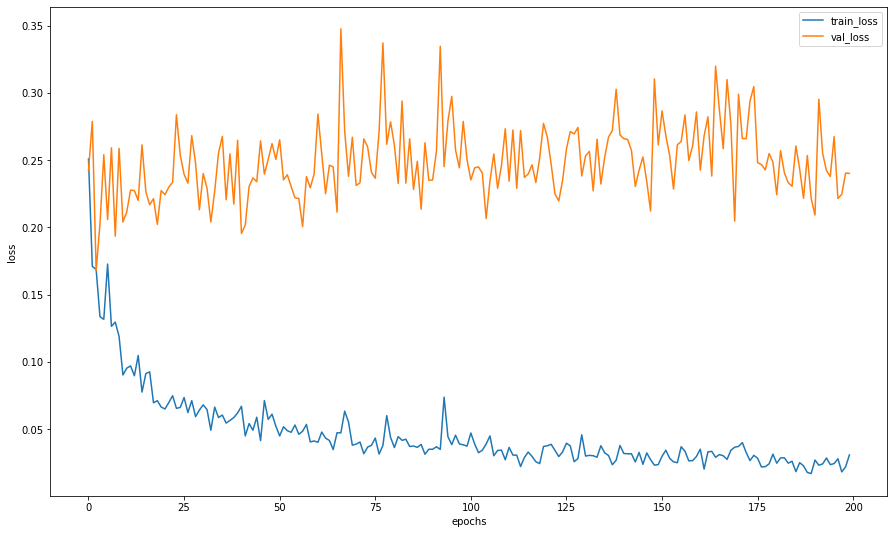

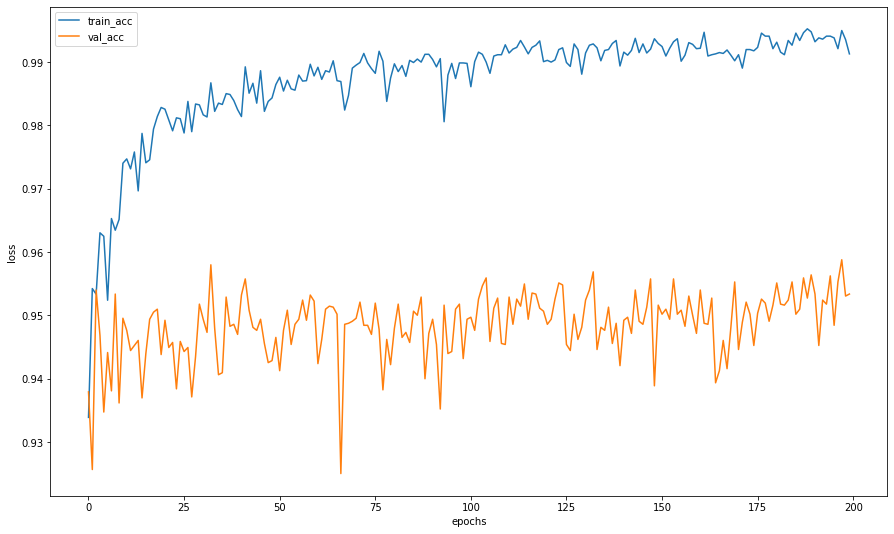

In [0]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")

plt.figure(figsize=(15, 9))
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [0]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model_ft, test_loader)

preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [0]:
submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [0]:
submit.to_csv('submission.csv', index=False)

In [0]:
#!kaggle competitions submit -c simpsons4 -f 'submission.csv' -m "Message"

100%|██████████████████████████████████████| 25.7k/25.7k [00:05<00:00, 4.98kB/s]
Successfully submitted to Journey to Springfield

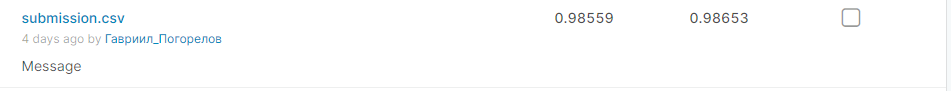

In [0]:
# Получили вполне себе неплохой результат
from IPython.core.display import Image, display
display(Image('/content/renset_train.PNG', width=1000, unconfined=True))

### Добучим сеть на полном датасете

In [0]:
history = train(all_dataset, val_dataset, model=model_ft, epochs=200, batch_size=256)


epoch:   0%|          | 0/200 [00:00<?, ?it/s]

loss 0.02587937176074902


epoch:   0%|          | 1/200 [01:35<5:16:32, 95.44s/it]


Epoch 001 train_loss: 0.0259     val_loss 0.2788 train_acc 0.9930 val_acc 0.9546
loss 0.023125592866296094


epoch:   1%|          | 2/200 [03:10<5:14:20, 95.26s/it]


Epoch 002 train_loss: 0.0231     val_loss 0.2532 train_acc 0.9936 val_acc 0.9527
loss 0.024604850219348967


epoch:   2%|▏         | 3/200 [04:45<5:12:18, 95.12s/it]


Epoch 003 train_loss: 0.0246     val_loss 0.3169 train_acc 0.9935 val_acc 0.9486
loss 0.024695666688377756


epoch:   2%|▏         | 4/200 [06:19<5:10:12, 94.96s/it]


Epoch 004 train_loss: 0.0247     val_loss 0.2592 train_acc 0.9939 val_acc 0.9518
loss 0.029622689955093366


epoch:   2%|▎         | 5/200 [07:54<5:08:39, 94.97s/it]


Epoch 005 train_loss: 0.0296     val_loss 0.3086 train_acc 0.9923 val_acc 0.9484
loss 0.036105043393668


epoch:   3%|▎         | 6/200 [09:29<5:06:38, 94.84s/it]


Epoch 006 train_loss: 0.0361     val_loss 0.2955 train_acc 0.9908 val_acc 0.9427
loss 0.03509416385858667


epoch:   4%|▎         | 7/200 [11:05<5:06:10, 95.18s/it]


Epoch 007 train_loss: 0.0351     val_loss 0.2849 train_acc 0.9907 val_acc 0.9495
loss 0.034538887112176314


epoch:   4%|▍         | 8/200 [12:40<5:04:21, 95.11s/it]


Epoch 008 train_loss: 0.0345     val_loss 0.2551 train_acc 0.9913 val_acc 0.9494
loss 0.02086945901876105


epoch:   4%|▍         | 9/200 [14:14<5:02:20, 94.98s/it]


Epoch 009 train_loss: 0.0209     val_loss 0.2293 train_acc 0.9943 val_acc 0.9554
loss 0.02431032798289673


epoch:   5%|▌         | 10/200 [15:50<5:01:04, 95.08s/it]


Epoch 010 train_loss: 0.0243     val_loss 0.2818 train_acc 0.9945 val_acc 0.9481
loss 0.02691016888560809


epoch:   6%|▌         | 11/200 [17:24<4:59:05, 94.95s/it]


Epoch 011 train_loss: 0.0269     val_loss 0.2742 train_acc 0.9928 val_acc 0.9473
loss 0.02300377875994994


epoch:   6%|▌         | 12/200 [18:59<4:57:10, 94.84s/it]


Epoch 012 train_loss: 0.0230     val_loss 0.2423 train_acc 0.9941 val_acc 0.9554
loss 0.026407706747141067


epoch:   6%|▋         | 13/200 [20:35<4:56:30, 95.14s/it]


Epoch 013 train_loss: 0.0264     val_loss 0.2650 train_acc 0.9931 val_acc 0.9439
loss 0.02842815762179415


epoch:   7%|▋         | 14/200 [22:10<4:55:32, 95.34s/it]


Epoch 014 train_loss: 0.0284     val_loss 0.2660 train_acc 0.9929 val_acc 0.9508
loss 0.033070883940884234


epoch:   8%|▊         | 15/200 [23:46<4:54:24, 95.49s/it]


Epoch 015 train_loss: 0.0331     val_loss 0.2430 train_acc 0.9912 val_acc 0.9495
loss 0.021721469509795217


epoch:   8%|▊         | 16/200 [25:21<4:52:22, 95.34s/it]


Epoch 016 train_loss: 0.0217     val_loss 0.2721 train_acc 0.9945 val_acc 0.9513
loss 0.026464244749572843


epoch:   8%|▊         | 17/200 [26:56<4:50:39, 95.30s/it]


Epoch 017 train_loss: 0.0265     val_loss 0.2781 train_acc 0.9929 val_acc 0.9545
loss 0.03155035326001017


epoch:   9%|▉         | 18/200 [28:32<4:49:09, 95.33s/it]


Epoch 018 train_loss: 0.0316     val_loss 0.2680 train_acc 0.9924 val_acc 0.9447
loss 0.022424605769426037


epoch:  10%|▉         | 19/200 [30:07<4:47:12, 95.21s/it]


Epoch 019 train_loss: 0.0224     val_loss 0.2173 train_acc 0.9931 val_acc 0.9576
loss 0.02586702052533061


epoch:  10%|█         | 20/200 [31:42<4:45:42, 95.24s/it]


Epoch 020 train_loss: 0.0259     val_loss 0.2699 train_acc 0.9933 val_acc 0.9482
loss 0.021293967780741965


epoch:  10%|█         | 21/200 [33:17<4:44:00, 95.20s/it]


Epoch 021 train_loss: 0.0213     val_loss 0.2301 train_acc 0.9937 val_acc 0.9543
loss 0.030177922977993515


epoch:  11%|█         | 22/200 [34:52<4:42:06, 95.09s/it]


Epoch 022 train_loss: 0.0302     val_loss 0.2740 train_acc 0.9927 val_acc 0.9510
loss 0.026877218242022338


epoch:  12%|█▏        | 23/200 [36:27<4:40:40, 95.15s/it]


Epoch 023 train_loss: 0.0269     val_loss 0.2580 train_acc 0.9926 val_acc 0.9529
loss 0.019932661013075302


epoch:  12%|█▏        | 24/200 [38:02<4:38:55, 95.09s/it]


Epoch 024 train_loss: 0.0199     val_loss 0.2257 train_acc 0.9942 val_acc 0.9551
loss 0.022501990998273522


epoch:  12%|█▎        | 25/200 [39:38<4:37:39, 95.20s/it]


Epoch 025 train_loss: 0.0225     val_loss 0.2435 train_acc 0.9950 val_acc 0.9502
loss 0.01868332586107112


epoch:  13%|█▎        | 26/200 [41:14<4:36:45, 95.43s/it]


Epoch 026 train_loss: 0.0187     val_loss 0.2571 train_acc 0.9946 val_acc 0.9561
loss 0.02691633988390203


epoch:  14%|█▎        | 27/200 [42:50<4:35:29, 95.55s/it]


Epoch 027 train_loss: 0.0269     val_loss 0.2476 train_acc 0.9926 val_acc 0.9524
loss 0.03007222569872314


epoch:  14%|█▍        | 28/200 [44:25<4:33:58, 95.57s/it]


Epoch 028 train_loss: 0.0301     val_loss 0.2967 train_acc 0.9924 val_acc 0.9435
loss 0.03310193567086332


epoch:  14%|█▍        | 29/200 [46:01<4:32:18, 95.55s/it]


Epoch 029 train_loss: 0.0331     val_loss 0.2600 train_acc 0.9902 val_acc 0.9522
loss 0.026784840941517864


epoch:  15%|█▌        | 30/200 [47:35<4:30:01, 95.30s/it]


Epoch 030 train_loss: 0.0268     val_loss 0.2501 train_acc 0.9928 val_acc 0.9508
loss 0.02154808240345652


epoch:  16%|█▌        | 31/200 [49:10<4:27:39, 95.03s/it]


Epoch 031 train_loss: 0.0215     val_loss 0.2631 train_acc 0.9939 val_acc 0.9562
loss 0.018701228936084797


epoch:  16%|█▌        | 32/200 [50:45<4:26:02, 95.02s/it]


Epoch 032 train_loss: 0.0187     val_loss 0.2478 train_acc 0.9950 val_acc 0.9538
loss 0.025326561077738723


epoch:  16%|█▋        | 33/200 [52:20<4:24:47, 95.14s/it]


Epoch 033 train_loss: 0.0253     val_loss 0.2676 train_acc 0.9928 val_acc 0.9510
loss 0.029104340084607442


epoch:  17%|█▋        | 34/200 [53:56<4:24:00, 95.42s/it]


Epoch 034 train_loss: 0.0291     val_loss 0.2786 train_acc 0.9933 val_acc 0.9505
loss 0.02117130223311835


epoch:  18%|█▊        | 35/200 [55:32<4:22:19, 95.39s/it]


Epoch 035 train_loss: 0.0212     val_loss 0.2297 train_acc 0.9943 val_acc 0.9580
loss 0.0175295392483092


epoch:  18%|█▊        | 36/200 [57:07<4:20:53, 95.45s/it]


Epoch 036 train_loss: 0.0175     val_loss 0.2519 train_acc 0.9949 val_acc 0.9532
loss 0.017669187081126168


epoch:  18%|█▊        | 37/200 [58:42<4:19:05, 95.37s/it]


Epoch 037 train_loss: 0.0177     val_loss 0.2408 train_acc 0.9947 val_acc 0.9524
loss 0.026302804475023377


epoch:  19%|█▉        | 38/200 [1:00:18<4:17:24, 95.34s/it]


Epoch 038 train_loss: 0.0263     val_loss 0.2618 train_acc 0.9917 val_acc 0.9518
loss 0.025991638421825215


epoch:  20%|█▉        | 39/200 [1:01:53<4:15:37, 95.26s/it]


Epoch 039 train_loss: 0.0260     val_loss 0.2799 train_acc 0.9934 val_acc 0.9478
loss 0.03069989098767822


epoch:  20%|██        | 40/200 [1:03:27<4:13:37, 95.11s/it]


Epoch 040 train_loss: 0.0307     val_loss 0.2361 train_acc 0.9921 val_acc 0.9516
loss 0.02146667614782588


epoch:  20%|██        | 41/200 [1:05:03<4:12:11, 95.16s/it]


Epoch 041 train_loss: 0.0215     val_loss 0.2215 train_acc 0.9941 val_acc 0.9548
loss 0.01889275464165791


epoch:  21%|██        | 42/200 [1:06:38<4:10:30, 95.13s/it]


Epoch 042 train_loss: 0.0189     val_loss 0.2730 train_acc 0.9939 val_acc 0.9530
loss 0.024657624030936635


epoch:  22%|██▏       | 43/200 [1:08:13<4:09:13, 95.24s/it]


Epoch 043 train_loss: 0.0247     val_loss 0.2653 train_acc 0.9929 val_acc 0.9524
loss 0.019735136132169075


epoch:  22%|██▏       | 44/200 [1:09:48<4:07:30, 95.20s/it]


Epoch 044 train_loss: 0.0197     val_loss 0.2490 train_acc 0.9946 val_acc 0.9551
loss 0.021082748250846023


epoch:  22%|██▎       | 45/200 [1:11:24<4:05:55, 95.19s/it]


Epoch 045 train_loss: 0.0211     val_loss 0.2221 train_acc 0.9945 val_acc 0.9556
loss 0.01424137102645929


epoch:  23%|██▎       | 46/200 [1:12:59<4:04:23, 95.22s/it]


Epoch 046 train_loss: 0.0142     val_loss 0.2477 train_acc 0.9957 val_acc 0.9538
loss 0.015673186865018125


epoch:  24%|██▎       | 47/200 [1:14:34<4:02:45, 95.20s/it]


Epoch 047 train_loss: 0.0157     val_loss 0.2515 train_acc 0.9954 val_acc 0.9513
loss 0.024318452264752835


epoch:  24%|██▍       | 48/200 [1:16:09<4:01:16, 95.24s/it]


Epoch 048 train_loss: 0.0243     val_loss 0.2606 train_acc 0.9932 val_acc 0.9506
loss 0.02074550678788912


epoch:  24%|██▍       | 49/200 [1:17:45<3:59:59, 95.36s/it]


Epoch 049 train_loss: 0.0207     val_loss 0.2727 train_acc 0.9943 val_acc 0.9525
loss 0.02271502901173481


epoch:  25%|██▌       | 50/200 [1:19:20<3:58:06, 95.24s/it]


Epoch 050 train_loss: 0.0227     val_loss 0.2667 train_acc 0.9933 val_acc 0.9482
loss 0.03028847244943482


epoch:  26%|██▌       | 51/200 [1:20:56<3:56:56, 95.42s/it]


Epoch 051 train_loss: 0.0303     val_loss 0.2579 train_acc 0.9919 val_acc 0.9502
loss 0.020073363427170962


epoch:  26%|██▌       | 52/200 [1:22:31<3:54:52, 95.22s/it]


Epoch 052 train_loss: 0.0201     val_loss 0.2574 train_acc 0.9943 val_acc 0.9530
loss 0.02212501359668875


epoch:  26%|██▋       | 53/200 [1:24:06<3:53:21, 95.25s/it]


Epoch 053 train_loss: 0.0221     val_loss 0.2210 train_acc 0.9943 val_acc 0.9553
loss 0.020699806911584268


epoch:  27%|██▋       | 54/200 [1:25:41<3:51:43, 95.23s/it]


Epoch 054 train_loss: 0.0207     val_loss 0.2401 train_acc 0.9945 val_acc 0.9521
loss 0.021186162030110322


epoch:  28%|██▊       | 55/200 [1:27:16<3:50:08, 95.23s/it]


Epoch 055 train_loss: 0.0212     val_loss 0.3140 train_acc 0.9934 val_acc 0.9462
loss 0.020114569861594645


epoch:  28%|██▊       | 56/200 [1:28:51<3:48:14, 95.10s/it]


Epoch 056 train_loss: 0.0201     val_loss 0.2480 train_acc 0.9949 val_acc 0.9537
loss 0.01901753763084931


epoch:  28%|██▊       | 57/200 [1:30:27<3:47:07, 95.30s/it]


Epoch 057 train_loss: 0.0190     val_loss 0.2660 train_acc 0.9947 val_acc 0.9530
loss 0.022868797703707967


epoch:  29%|██▉       | 58/200 [1:32:02<3:45:13, 95.16s/it]


Epoch 058 train_loss: 0.0229     val_loss 0.2516 train_acc 0.9928 val_acc 0.9533
loss 0.022609144245904437


epoch:  30%|██▉       | 59/200 [1:33:37<3:43:48, 95.24s/it]


Epoch 059 train_loss: 0.0226     val_loss 0.2596 train_acc 0.9937 val_acc 0.9486
loss 0.025436172433569187


epoch:  30%|███       | 60/200 [1:35:13<3:42:39, 95.42s/it]


Epoch 060 train_loss: 0.0254     val_loss 0.2634 train_acc 0.9929 val_acc 0.9476
loss 0.02406968805698835


epoch:  30%|███       | 61/200 [1:36:49<3:41:10, 95.47s/it]


Epoch 061 train_loss: 0.0241     val_loss 0.2539 train_acc 0.9929 val_acc 0.9529
loss 0.018226044786787517


epoch:  31%|███       | 62/200 [1:38:23<3:39:05, 95.26s/it]


Epoch 062 train_loss: 0.0182     val_loss 0.2509 train_acc 0.9947 val_acc 0.9556
loss 0.01578982184464329


epoch:  32%|███▏      | 63/200 [1:39:59<3:37:31, 95.27s/it]


Epoch 063 train_loss: 0.0158     val_loss 0.2249 train_acc 0.9954 val_acc 0.9567
loss 0.015241012972521716


epoch:  32%|███▏      | 64/200 [1:41:34<3:35:59, 95.29s/it]


Epoch 064 train_loss: 0.0152     val_loss 0.2827 train_acc 0.9957 val_acc 0.9505
loss 0.017118889180976295


epoch:  32%|███▎      | 65/200 [1:43:09<3:34:28, 95.32s/it]


Epoch 065 train_loss: 0.0171     val_loss 0.2381 train_acc 0.9958 val_acc 0.9567
loss 0.026444252871383


epoch:  33%|███▎      | 66/200 [1:44:44<3:32:24, 95.11s/it]


Epoch 066 train_loss: 0.0264     val_loss 0.2565 train_acc 0.9928 val_acc 0.9492
loss 0.0212977621601338


epoch:  34%|███▎      | 67/200 [1:46:19<3:31:05, 95.23s/it]


Epoch 067 train_loss: 0.0213     val_loss 0.2382 train_acc 0.9935 val_acc 0.9551
loss 0.017751457202460085


epoch:  34%|███▍      | 68/200 [1:47:55<3:29:58, 95.45s/it]


Epoch 068 train_loss: 0.0178     val_loss 0.2430 train_acc 0.9952 val_acc 0.9557
loss 0.02616066301056816


epoch:  34%|███▍      | 69/200 [1:49:32<3:29:10, 95.81s/it]


Epoch 069 train_loss: 0.0262     val_loss 0.2397 train_acc 0.9930 val_acc 0.9538
loss 0.01986685795712013


epoch:  35%|███▌      | 70/200 [1:51:08<3:27:39, 95.84s/it]


Epoch 070 train_loss: 0.0199     val_loss 0.2343 train_acc 0.9943 val_acc 0.9545
loss 0.01762799727747296


epoch:  36%|███▌      | 71/200 [1:52:43<3:25:50, 95.74s/it]


Epoch 071 train_loss: 0.0176     val_loss 0.2758 train_acc 0.9960 val_acc 0.9486
loss 0.03243883562914256


epoch:  36%|███▌      | 72/200 [1:54:19<3:23:55, 95.59s/it]


Epoch 072 train_loss: 0.0324     val_loss 0.3117 train_acc 0.9911 val_acc 0.9452
loss 0.02951800427471079


epoch:  36%|███▋      | 73/200 [1:55:55<3:22:33, 95.70s/it]


Epoch 073 train_loss: 0.0295     val_loss 0.2700 train_acc 0.9917 val_acc 0.9521
loss 0.01868607175929142


epoch:  37%|███▋      | 74/200 [1:57:30<3:20:42, 95.58s/it]


Epoch 074 train_loss: 0.0187     val_loss 0.2367 train_acc 0.9947 val_acc 0.9578
loss 0.02458367656746933


epoch:  38%|███▊      | 75/200 [1:59:05<3:18:54, 95.48s/it]


Epoch 075 train_loss: 0.0246     val_loss 0.2425 train_acc 0.9932 val_acc 0.9538
loss 0.02280293787728791


epoch:  38%|███▊      | 76/200 [2:00:40<3:17:01, 95.34s/it]


Epoch 076 train_loss: 0.0228     val_loss 0.1988 train_acc 0.9937 val_acc 0.9607
loss 0.026916870291493613


epoch:  38%|███▊      | 77/200 [2:02:15<3:15:14, 95.24s/it]


Epoch 077 train_loss: 0.0269     val_loss 0.2355 train_acc 0.9928 val_acc 0.9541
loss 0.01790125568519439


epoch:  39%|███▉      | 78/200 [2:03:51<3:13:49, 95.32s/it]


Epoch 078 train_loss: 0.0179     val_loss 0.2380 train_acc 0.9953 val_acc 0.9541
loss 0.016592826396542134


epoch:  40%|███▉      | 79/200 [2:05:26<3:12:26, 95.43s/it]


Epoch 079 train_loss: 0.0166     val_loss 0.2329 train_acc 0.9953 val_acc 0.9562
loss 0.019776947022996812


epoch:  40%|████      | 80/200 [2:07:02<3:10:46, 95.38s/it]


Epoch 080 train_loss: 0.0198     val_loss 0.2338 train_acc 0.9947 val_acc 0.9530
loss 0.015550669784151287


epoch:  40%|████      | 81/200 [2:08:38<3:09:37, 95.61s/it]


Epoch 081 train_loss: 0.0156     val_loss 0.2620 train_acc 0.9958 val_acc 0.9557
loss 0.01752702799691446


epoch:  41%|████      | 82/200 [2:10:14<3:08:05, 95.64s/it]


Epoch 082 train_loss: 0.0175     val_loss 0.2492 train_acc 0.9946 val_acc 0.9524
loss 0.01696883651631884


epoch:  42%|████▏     | 83/200 [2:11:49<3:06:38, 95.71s/it]


Epoch 083 train_loss: 0.0170     val_loss 0.2280 train_acc 0.9952 val_acc 0.9568
loss 0.02167972327646465


epoch:  42%|████▏     | 84/200 [2:13:25<3:04:53, 95.63s/it]


Epoch 084 train_loss: 0.0217     val_loss 0.2345 train_acc 0.9942 val_acc 0.9537
loss 0.022552123986894417


epoch:  42%|████▎     | 85/200 [2:15:00<3:03:15, 95.61s/it]


Epoch 085 train_loss: 0.0226     val_loss 0.2773 train_acc 0.9938 val_acc 0.9498
loss 0.02352506795102709


epoch:  43%|████▎     | 86/200 [2:16:36<3:01:30, 95.53s/it]


Epoch 086 train_loss: 0.0235     val_loss 0.2734 train_acc 0.9928 val_acc 0.9508
loss 0.032302892830769196


epoch:  44%|████▎     | 87/200 [2:18:11<2:59:52, 95.51s/it]


Epoch 087 train_loss: 0.0323     val_loss 0.2416 train_acc 0.9911 val_acc 0.9559
loss 0.020464919387250844


epoch:  44%|████▍     | 88/200 [2:19:47<2:58:11, 95.46s/it]


Epoch 088 train_loss: 0.0205     val_loss 0.2607 train_acc 0.9943 val_acc 0.9524
loss 0.02095816536567353


epoch:  44%|████▍     | 89/200 [2:21:22<2:56:19, 95.31s/it]


Epoch 089 train_loss: 0.0210     val_loss 0.2396 train_acc 0.9939 val_acc 0.9532
loss 0.023800983248443878


epoch:  45%|████▌     | 90/200 [2:22:57<2:54:47, 95.35s/it]


Epoch 090 train_loss: 0.0238     val_loss 0.2276 train_acc 0.9928 val_acc 0.9530
loss 0.014162108602366708


epoch:  46%|████▌     | 91/200 [2:24:33<2:53:21, 95.42s/it]


Epoch 091 train_loss: 0.0142     val_loss 0.2654 train_acc 0.9956 val_acc 0.9527
loss 0.025191938750039576


epoch:  46%|████▌     | 92/200 [2:26:08<2:51:37, 95.35s/it]


Epoch 092 train_loss: 0.0252     val_loss 0.2525 train_acc 0.9941 val_acc 0.9510
loss 0.024953438984602297


epoch:  46%|████▋     | 93/200 [2:27:43<2:49:55, 95.28s/it]


Epoch 093 train_loss: 0.0250     val_loss 0.2102 train_acc 0.9937 val_acc 0.9556
loss 0.012874105085749899


epoch:  47%|████▋     | 94/200 [2:29:18<2:48:05, 95.15s/it]


Epoch 094 train_loss: 0.0129     val_loss 0.2563 train_acc 0.9963 val_acc 0.9554
loss 0.01805698300819161


epoch:  48%|████▊     | 95/200 [2:30:53<2:46:46, 95.30s/it]


Epoch 095 train_loss: 0.0181     val_loss 0.2850 train_acc 0.9949 val_acc 0.9511
loss 0.025169223251053474


epoch:  48%|████▊     | 96/200 [2:32:29<2:45:11, 95.30s/it]


Epoch 096 train_loss: 0.0252     val_loss 0.2805 train_acc 0.9934 val_acc 0.9498
loss 0.015655039289799322


epoch:  48%|████▊     | 97/200 [2:34:04<2:43:23, 95.18s/it]


Epoch 097 train_loss: 0.0157     val_loss 0.2732 train_acc 0.9954 val_acc 0.9506
loss 0.03780806829101548


epoch:  49%|████▉     | 98/200 [2:35:39<2:41:55, 95.25s/it]


Epoch 098 train_loss: 0.0378     val_loss 0.2348 train_acc 0.9894 val_acc 0.9527
loss 0.021949135256964365


epoch:  50%|████▉     | 99/200 [2:37:14<2:40:18, 95.23s/it]


Epoch 099 train_loss: 0.0219     val_loss 0.2487 train_acc 0.9939 val_acc 0.9549
loss 0.022704060128483285


epoch:  50%|█████     | 100/200 [2:38:49<2:38:38, 95.19s/it]


Epoch 100 train_loss: 0.0227     val_loss 0.2353 train_acc 0.9943 val_acc 0.9568
loss 0.016097087953319763


epoch:  50%|█████     | 101/200 [2:40:25<2:37:10, 95.26s/it]


Epoch 101 train_loss: 0.0161     val_loss 0.2723 train_acc 0.9947 val_acc 0.9538
loss 0.01731572819373231


epoch:  51%|█████     | 102/200 [2:42:00<2:35:28, 95.19s/it]


Epoch 102 train_loss: 0.0173     val_loss 0.2438 train_acc 0.9951 val_acc 0.9567
loss 0.015518577451924025


epoch:  52%|█████▏    | 103/200 [2:43:35<2:33:58, 95.25s/it]


Epoch 103 train_loss: 0.0155     val_loss 0.2488 train_acc 0.9958 val_acc 0.9564
loss 0.020490100916539664


epoch:  52%|█████▏    | 104/200 [2:45:10<2:32:22, 95.23s/it]


Epoch 104 train_loss: 0.0205     val_loss 0.2174 train_acc 0.9952 val_acc 0.9567
loss 0.014539860494343691


epoch:  52%|█████▎    | 105/200 [2:46:45<2:30:33, 95.09s/it]


Epoch 105 train_loss: 0.0145     val_loss 0.2529 train_acc 0.9960 val_acc 0.9521
loss 0.019791041146591384


epoch:  53%|█████▎    | 106/200 [2:48:20<2:28:50, 95.01s/it]


Epoch 106 train_loss: 0.0198     val_loss 0.2411 train_acc 0.9942 val_acc 0.9562
loss 0.014455462664127805


epoch:  54%|█████▎    | 107/200 [2:49:55<2:27:32, 95.19s/it]


Epoch 107 train_loss: 0.0145     val_loss 0.2477 train_acc 0.9962 val_acc 0.9565
loss 0.025056458956242346


epoch:  54%|█████▍    | 108/200 [2:51:31<2:26:16, 95.39s/it]


Epoch 108 train_loss: 0.0251     val_loss 0.3011 train_acc 0.9926 val_acc 0.9467
loss 0.02366822803212532


epoch:  55%|█████▍    | 109/200 [2:53:07<2:24:35, 95.34s/it]


Epoch 109 train_loss: 0.0237     val_loss 0.2512 train_acc 0.9931 val_acc 0.9522
loss 0.015249533914215189


epoch:  55%|█████▌    | 110/200 [2:54:42<2:23:02, 95.36s/it]


Epoch 110 train_loss: 0.0152     val_loss 0.2213 train_acc 0.9949 val_acc 0.9570
loss 0.02211042860543078


epoch:  56%|█████▌    | 111/200 [2:56:17<2:21:16, 95.24s/it]


Epoch 111 train_loss: 0.0221     val_loss 0.2575 train_acc 0.9930 val_acc 0.9502
loss 0.01854458505626279


epoch:  56%|█████▌    | 112/200 [2:57:52<2:19:35, 95.18s/it]


Epoch 112 train_loss: 0.0185     val_loss 0.2654 train_acc 0.9940 val_acc 0.9525
loss 0.0541155628919996


epoch:  56%|█████▋    | 113/200 [2:59:27<2:17:46, 95.02s/it]


Epoch 113 train_loss: 0.0541     val_loss 0.3008 train_acc 0.9876 val_acc 0.9432
loss 0.018728739733725717


epoch:  57%|█████▋    | 114/200 [3:01:02<2:16:27, 95.20s/it]


Epoch 114 train_loss: 0.0187     val_loss 0.2663 train_acc 0.9943 val_acc 0.9543
loss 0.02115063335264785


epoch:  57%|█████▊    | 115/200 [3:02:38<2:15:11, 95.42s/it]


Epoch 115 train_loss: 0.0212     val_loss 0.2627 train_acc 0.9941 val_acc 0.9537
loss 0.022773956212927046


epoch:  58%|█████▊    | 116/200 [3:04:14<2:13:34, 95.42s/it]


Epoch 116 train_loss: 0.0228     val_loss 0.2651 train_acc 0.9939 val_acc 0.9508
loss 0.02031498892926639


epoch:  58%|█████▊    | 117/200 [3:05:49<2:11:59, 95.42s/it]


Epoch 117 train_loss: 0.0203     val_loss 0.2704 train_acc 0.9946 val_acc 0.9513
loss 0.0207897727521633


epoch:  59%|█████▉    | 118/200 [3:07:24<2:10:23, 95.41s/it]


Epoch 118 train_loss: 0.0208     val_loss 0.2493 train_acc 0.9947 val_acc 0.9541
loss 0.013522551662743144


epoch:  60%|█████▉    | 119/200 [3:09:00<2:08:54, 95.49s/it]


Epoch 119 train_loss: 0.0135     val_loss 0.2238 train_acc 0.9963 val_acc 0.9583
loss 0.01200654069727242


epoch:  60%|██████    | 120/200 [3:10:35<2:07:10, 95.38s/it]


Epoch 120 train_loss: 0.0120     val_loss 0.2246 train_acc 0.9962 val_acc 0.9597
loss 0.016493149523736723


epoch:  60%|██████    | 121/200 [3:12:10<2:05:26, 95.28s/it]


Epoch 121 train_loss: 0.0165     val_loss 0.2455 train_acc 0.9958 val_acc 0.9543
loss 0.0214244159388553


epoch:  61%|██████    | 122/200 [3:13:45<2:03:51, 95.28s/it]


Epoch 122 train_loss: 0.0214     val_loss 0.2449 train_acc 0.9941 val_acc 0.9521
loss 0.016873118564221974


epoch:  62%|██████▏   | 123/200 [3:15:21<2:02:24, 95.39s/it]


Epoch 123 train_loss: 0.0169     val_loss 0.2544 train_acc 0.9950 val_acc 0.9546
loss 0.015792281976206062


epoch:  62%|██████▏   | 124/200 [3:16:56<2:00:46, 95.35s/it]


Epoch 124 train_loss: 0.0158     val_loss 0.2622 train_acc 0.9954 val_acc 0.9553
loss 0.0195967794052386


epoch:  62%|██████▎   | 125/200 [3:18:32<1:59:18, 95.44s/it]


Epoch 125 train_loss: 0.0196     val_loss 0.2325 train_acc 0.9948 val_acc 0.9518
loss 0.016954089479509094


epoch:  63%|██████▎   | 126/200 [3:20:07<1:57:37, 95.37s/it]


Epoch 126 train_loss: 0.0170     val_loss 0.2390 train_acc 0.9946 val_acc 0.9540
loss 0.01825144273492838


epoch:  64%|██████▎   | 127/200 [3:21:42<1:55:51, 95.22s/it]


Epoch 127 train_loss: 0.0183     val_loss 0.2290 train_acc 0.9946 val_acc 0.9581
loss 0.013803202298642148


epoch:  64%|██████▍   | 128/200 [3:23:18<1:54:22, 95.31s/it]


Epoch 128 train_loss: 0.0138     val_loss 0.2627 train_acc 0.9959 val_acc 0.9537
loss 0.019219983245006116


epoch:  64%|██████▍   | 129/200 [3:24:54<1:53:04, 95.56s/it]


Epoch 129 train_loss: 0.0192     val_loss 0.2652 train_acc 0.9947 val_acc 0.9514
loss 0.026273569637105008


epoch:  65%|██████▌   | 130/200 [3:26:29<1:51:16, 95.38s/it]


Epoch 130 train_loss: 0.0263     val_loss 0.2343 train_acc 0.9926 val_acc 0.9561
loss 0.02888247307504634


epoch:  66%|██████▌   | 131/200 [3:28:04<1:49:34, 95.29s/it]


Epoch 131 train_loss: 0.0289     val_loss 0.2379 train_acc 0.9928 val_acc 0.9556
loss 0.019269137021882165


epoch:  66%|██████▌   | 132/200 [3:29:39<1:47:54, 95.22s/it]


Epoch 132 train_loss: 0.0193     val_loss 0.2460 train_acc 0.9953 val_acc 0.9559
loss 0.01623755937957897


epoch:  66%|██████▋   | 133/200 [3:31:14<1:46:23, 95.28s/it]


Epoch 133 train_loss: 0.0162     val_loss 0.2313 train_acc 0.9957 val_acc 0.9592
loss 0.022143616683761826


epoch:  67%|██████▋   | 134/200 [3:32:49<1:44:46, 95.24s/it]


Epoch 134 train_loss: 0.0221     val_loss 0.2176 train_acc 0.9939 val_acc 0.9586
loss 0.011589822019853644


epoch:  68%|██████▊   | 135/200 [3:34:25<1:43:16, 95.33s/it]


Epoch 135 train_loss: 0.0116     val_loss 0.2365 train_acc 0.9962 val_acc 0.9588
loss 0.014721277739939361


epoch:  68%|██████▊   | 136/200 [3:36:01<1:41:44, 95.39s/it]


Epoch 136 train_loss: 0.0147     val_loss 0.2757 train_acc 0.9957 val_acc 0.9505
loss 0.043307777871221094


epoch:  68%|██████▊   | 137/200 [3:37:36<1:40:07, 95.35s/it]


Epoch 137 train_loss: 0.0433     val_loss 0.2537 train_acc 0.9895 val_acc 0.9535
loss 0.023686886929997094


epoch:  69%|██████▉   | 138/200 [3:39:11<1:38:31, 95.35s/it]


Epoch 138 train_loss: 0.0237     val_loss 0.3002 train_acc 0.9933 val_acc 0.9452
loss 0.034871049543885514


epoch:  70%|██████▉   | 139/200 [3:40:47<1:36:59, 95.40s/it]


Epoch 139 train_loss: 0.0349     val_loss 0.2995 train_acc 0.9902 val_acc 0.9479
loss 0.02607097666737858


epoch:  70%|███████   | 140/200 [3:42:22<1:35:28, 95.47s/it]


Epoch 140 train_loss: 0.0261     val_loss 0.2714 train_acc 0.9928 val_acc 0.9525
loss 0.021443523277946457


epoch:  70%|███████   | 141/200 [3:43:57<1:33:45, 95.35s/it]


Epoch 141 train_loss: 0.0214     val_loss 0.2289 train_acc 0.9938 val_acc 0.9583
loss 0.016988236642318896


epoch:  71%|███████   | 142/200 [3:45:33<1:32:07, 95.31s/it]


Epoch 142 train_loss: 0.0170     val_loss 0.2423 train_acc 0.9952 val_acc 0.9551
loss 0.0162600783290178


epoch:  72%|███████▏  | 143/200 [3:47:07<1:30:25, 95.19s/it]


Epoch 143 train_loss: 0.0163     val_loss 0.2433 train_acc 0.9958 val_acc 0.9576
loss 0.014224031801831079


epoch:  72%|███████▏  | 144/200 [3:48:42<1:28:47, 95.14s/it]


Epoch 144 train_loss: 0.0142     val_loss 0.2206 train_acc 0.9964 val_acc 0.9607
loss 0.014437606529361052


epoch:  72%|███████▎  | 145/200 [3:50:18<1:27:23, 95.34s/it]


Epoch 145 train_loss: 0.0144     val_loss 0.2381 train_acc 0.9960 val_acc 0.9556
loss 0.015702552661060853


epoch:  73%|███████▎  | 146/200 [3:51:54<1:25:46, 95.30s/it]


Epoch 146 train_loss: 0.0157     val_loss 0.2607 train_acc 0.9955 val_acc 0.9567
loss 0.018010446896992275


epoch:  74%|███████▎  | 147/200 [3:53:29<1:24:07, 95.24s/it]


Epoch 147 train_loss: 0.0180     val_loss 0.2531 train_acc 0.9950 val_acc 0.9546
loss 0.016778319775674302


epoch:  74%|███████▍  | 148/200 [3:55:04<1:22:40, 95.40s/it]


Epoch 148 train_loss: 0.0168     val_loss 0.2157 train_acc 0.9948 val_acc 0.9576
loss 0.01606671497228812


epoch:  74%|███████▍  | 149/200 [3:56:40<1:21:03, 95.35s/it]


Epoch 149 train_loss: 0.0161     val_loss 0.2623 train_acc 0.9947 val_acc 0.9557
loss 0.019505912003104253


epoch:  75%|███████▌  | 150/200 [3:58:15<1:19:24, 95.30s/it]


Epoch 150 train_loss: 0.0195     val_loss 0.2748 train_acc 0.9946 val_acc 0.9513
loss 0.021276435159827623


epoch:  76%|███████▌  | 151/200 [3:59:50<1:17:41, 95.13s/it]


Epoch 151 train_loss: 0.0213     val_loss 0.2770 train_acc 0.9951 val_acc 0.9468
loss 0.021867148237684122


epoch:  76%|███████▌  | 152/200 [4:01:24<1:16:02, 95.05s/it]


Epoch 152 train_loss: 0.0219     val_loss 0.2247 train_acc 0.9941 val_acc 0.9559
loss 0.01856210893527866


epoch:  76%|███████▋  | 153/200 [4:03:00<1:14:28, 95.07s/it]


Epoch 153 train_loss: 0.0186     val_loss 0.2148 train_acc 0.9945 val_acc 0.9584
loss 0.016733505661737706


epoch:  77%|███████▋  | 154/200 [4:04:35<1:12:59, 95.20s/it]


Epoch 154 train_loss: 0.0167     val_loss 0.2682 train_acc 0.9958 val_acc 0.9500
loss 0.01856062746351135


epoch:  78%|███████▊  | 155/200 [4:06:10<1:11:20, 95.12s/it]


Epoch 155 train_loss: 0.0186     val_loss 0.2488 train_acc 0.9956 val_acc 0.9521
loss 0.017469570286197493


epoch:  78%|███████▊  | 156/200 [4:07:45<1:09:46, 95.15s/it]


Epoch 156 train_loss: 0.0175     val_loss 0.2216 train_acc 0.9949 val_acc 0.9583
loss 0.014286466312516332


epoch:  78%|███████▊  | 157/200 [4:09:21<1:08:16, 95.26s/it]


Epoch 157 train_loss: 0.0143     val_loss 0.2546 train_acc 0.9961 val_acc 0.9570
loss 0.017276922916352955


epoch:  79%|███████▉  | 158/200 [4:10:56<1:06:46, 95.40s/it]


Epoch 158 train_loss: 0.0173     val_loss 0.2387 train_acc 0.9954 val_acc 0.9565
loss 0.019580997839311727


epoch:  80%|███████▉  | 159/200 [4:12:33<1:05:21, 95.65s/it]


Epoch 159 train_loss: 0.0196     val_loss 0.2296 train_acc 0.9948 val_acc 0.9578
loss 0.013476643165488182


epoch:  80%|████████  | 160/200 [4:14:08<1:03:37, 95.44s/it]


Epoch 160 train_loss: 0.0135     val_loss 0.2442 train_acc 0.9956 val_acc 0.9554
loss 0.01726285259344708


epoch:  80%|████████  | 161/200 [4:15:43<1:02:01, 95.42s/it]


Epoch 161 train_loss: 0.0173     val_loss 0.2160 train_acc 0.9947 val_acc 0.9597
loss 0.012926695934615762


epoch:  81%|████████  | 162/200 [4:17:18<1:00:23, 95.35s/it]


Epoch 162 train_loss: 0.0129     val_loss 0.2377 train_acc 0.9967 val_acc 0.9578
loss 0.01381143126819792


epoch:  82%|████████▏ | 163/200 [4:18:53<58:44, 95.27s/it]  


Epoch 163 train_loss: 0.0138     val_loss 0.2545 train_acc 0.9957 val_acc 0.9522
loss 0.015337048877592595


epoch:  82%|████████▏ | 164/200 [4:20:29<57:10, 95.28s/it]


Epoch 164 train_loss: 0.0153     val_loss 0.2536 train_acc 0.9959 val_acc 0.9568
loss 0.029285517553673007


epoch:  82%|████████▎ | 165/200 [4:22:04<55:37, 95.36s/it]


Epoch 165 train_loss: 0.0293     val_loss 0.2457 train_acc 0.9926 val_acc 0.9589
loss 0.016597951354646024


epoch:  83%|████████▎ | 166/200 [4:23:40<54:03, 95.38s/it]


Epoch 166 train_loss: 0.0166     val_loss 0.2532 train_acc 0.9954 val_acc 0.9554
loss 0.02027817827594798


epoch:  84%|████████▎ | 167/200 [4:25:16<52:37, 95.69s/it]


Epoch 167 train_loss: 0.0203     val_loss 0.2702 train_acc 0.9945 val_acc 0.9553
loss 0.014169408346714521


epoch:  84%|████████▍ | 168/200 [4:26:51<50:56, 95.53s/it]


Epoch 168 train_loss: 0.0142     val_loss 0.2763 train_acc 0.9947 val_acc 0.9549
loss 0.018357060234039047


epoch:  84%|████████▍ | 169/200 [4:28:26<49:17, 95.39s/it]


Epoch 169 train_loss: 0.0184     val_loss 0.2512 train_acc 0.9945 val_acc 0.9541
loss 0.020986725505227108


epoch:  85%|████████▌ | 170/200 [4:30:01<47:40, 95.34s/it]


Epoch 170 train_loss: 0.0210     val_loss 0.2362 train_acc 0.9937 val_acc 0.9537
loss 0.01728107392906184


epoch:  86%|████████▌ | 171/200 [4:31:37<46:03, 95.30s/it]


Epoch 171 train_loss: 0.0173     val_loss 0.2241 train_acc 0.9947 val_acc 0.9578
loss 0.01475653614821077


epoch:  86%|████████▌ | 172/200 [4:33:11<44:24, 95.16s/it]


Epoch 172 train_loss: 0.0148     val_loss 0.2735 train_acc 0.9962 val_acc 0.9514
loss 0.015597952854826142


epoch:  86%|████████▋ | 173/200 [4:34:47<42:50, 95.19s/it]


Epoch 173 train_loss: 0.0156     val_loss 0.2215 train_acc 0.9954 val_acc 0.9565
loss 0.014511318991631434


epoch:  87%|████████▋ | 174/200 [4:36:22<41:14, 95.17s/it]


Epoch 174 train_loss: 0.0145     val_loss 0.2409 train_acc 0.9960 val_acc 0.9568
loss 0.016126764481758198


epoch:  88%|████████▊ | 175/200 [4:37:57<39:37, 95.10s/it]


Epoch 175 train_loss: 0.0161     val_loss 0.2449 train_acc 0.9953 val_acc 0.9591
loss 0.028840482369114892


epoch:  88%|████████▊ | 176/200 [4:39:32<38:04, 95.18s/it]


Epoch 176 train_loss: 0.0288     val_loss 0.2410 train_acc 0.9930 val_acc 0.9527
loss 0.012861288537100411


epoch:  88%|████████▊ | 177/200 [4:41:07<36:28, 95.14s/it]


Epoch 177 train_loss: 0.0129     val_loss 0.2266 train_acc 0.9965 val_acc 0.9589
loss 0.017270558674059192


epoch:  89%|████████▉ | 178/200 [4:42:42<34:53, 95.17s/it]


Epoch 178 train_loss: 0.0173     val_loss 0.2554 train_acc 0.9956 val_acc 0.9580
loss 0.01280451387483244


epoch:  90%|████████▉ | 179/200 [4:44:18<33:20, 95.25s/it]


Epoch 179 train_loss: 0.0128     val_loss 0.2391 train_acc 0.9960 val_acc 0.9583
loss 0.013491266369890826


epoch:  90%|█████████ | 180/200 [4:45:53<31:46, 95.33s/it]


Epoch 180 train_loss: 0.0135     val_loss 0.2656 train_acc 0.9960 val_acc 0.9576
loss 0.01446364090352146


epoch:  90%|█████████ | 181/200 [4:47:29<30:10, 95.29s/it]


Epoch 181 train_loss: 0.0145     val_loss 0.2420 train_acc 0.9957 val_acc 0.9588
loss 0.01492005065745823


epoch:  91%|█████████ | 182/200 [4:49:04<28:38, 95.47s/it]


Epoch 182 train_loss: 0.0149     val_loss 0.2646 train_acc 0.9956 val_acc 0.9532
loss 0.01600985139678528


epoch:  92%|█████████▏| 183/200 [4:50:39<27:00, 95.31s/it]


Epoch 183 train_loss: 0.0160     val_loss 0.2198 train_acc 0.9956 val_acc 0.9600
loss 0.0168787206815414


epoch:  92%|█████████▏| 184/200 [4:52:15<25:27, 95.45s/it]


Epoch 184 train_loss: 0.0169     val_loss 0.2303 train_acc 0.9957 val_acc 0.9581
loss 0.0155892049704841


epoch:  92%|█████████▎| 185/200 [4:53:50<23:51, 95.42s/it]


Epoch 185 train_loss: 0.0156     val_loss 0.2169 train_acc 0.9960 val_acc 0.9562
loss 0.011756390960637004


epoch:  93%|█████████▎| 186/200 [4:55:26<22:14, 95.33s/it]


Epoch 186 train_loss: 0.0118     val_loss 0.2605 train_acc 0.9965 val_acc 0.9561
loss 0.01522558030395888


epoch:  94%|█████████▎| 187/200 [4:57:01<20:39, 95.35s/it]


Epoch 187 train_loss: 0.0152     val_loss 0.2672 train_acc 0.9957 val_acc 0.9573
loss 0.016178113684929704


epoch:  94%|█████████▍| 188/200 [4:58:37<19:05, 95.44s/it]


Epoch 188 train_loss: 0.0162     val_loss 0.2381 train_acc 0.9960 val_acc 0.9596
loss 0.014046861334851128


epoch:  94%|█████████▍| 189/200 [5:00:12<17:29, 95.44s/it]


Epoch 189 train_loss: 0.0140     val_loss 0.2496 train_acc 0.9961 val_acc 0.9584
loss 0.009941540821231375


epoch:  95%|█████████▌| 190/200 [5:01:47<15:53, 95.33s/it]


Epoch 190 train_loss: 0.0099     val_loss 0.2795 train_acc 0.9970 val_acc 0.9545
loss 0.012984762011125245


epoch:  96%|█████████▌| 191/200 [5:03:23<14:17, 95.33s/it]


Epoch 191 train_loss: 0.0130     val_loss 0.2223 train_acc 0.9967 val_acc 0.9576
loss 0.021560940184458775


epoch:  96%|█████████▌| 192/200 [5:04:58<12:43, 95.40s/it]


Epoch 192 train_loss: 0.0216     val_loss 0.2798 train_acc 0.9938 val_acc 0.9521
loss 0.018404092354100485


epoch:  96%|█████████▋| 193/200 [5:06:33<11:06, 95.26s/it]


Epoch 193 train_loss: 0.0184     val_loss 0.2304 train_acc 0.9949 val_acc 0.9568
loss 0.01648613619361262


epoch:  97%|█████████▋| 194/200 [5:08:08<09:30, 95.11s/it]


Epoch 194 train_loss: 0.0165     val_loss 0.2494 train_acc 0.9958 val_acc 0.9521
loss 0.014585128710518447


epoch:  98%|█████████▊| 195/200 [5:09:43<07:55, 95.15s/it]


Epoch 195 train_loss: 0.0146     val_loss 0.2358 train_acc 0.9958 val_acc 0.9610
loss 0.017085330385588543


epoch:  98%|█████████▊| 196/200 [5:11:18<06:20, 95.21s/it]


Epoch 196 train_loss: 0.0171     val_loss 0.2757 train_acc 0.9956 val_acc 0.9551
loss 0.017772266593260616


epoch:  98%|█████████▊| 197/200 [5:12:53<04:45, 95.16s/it]


Epoch 197 train_loss: 0.0178     val_loss 0.2506 train_acc 0.9956 val_acc 0.9543
loss 0.01619650856639748


epoch:  99%|█████████▉| 198/200 [5:14:29<03:10, 95.30s/it]


Epoch 198 train_loss: 0.0162     val_loss 0.2579 train_acc 0.9961 val_acc 0.9538
loss 0.014566483727658149


epoch: 100%|█████████▉| 199/200 [5:16:05<01:35, 95.39s/it]


Epoch 199 train_loss: 0.0146     val_loss 0.2720 train_acc 0.9954 val_acc 0.9561
loss 0.014283406490796307


epoch: 100%|██████████| 200/200 [5:17:40<00:00, 95.30s/it]


Epoch 200 train_loss: 0.0143     val_loss 0.2744 train_acc 0.9960 val_acc 0.9567


In [13]:
# Загрузим сохраненную модельку
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1w9TkgvtlAmCq8DqFR9aLQ4pZyk0uVHKX' -O model_acc0.996997201938.pth

--2020-01-10 17:50:35--  https://docs.google.com/uc?export=download&id=1w9TkgvtlAmCq8DqFR9aLQ4pZyk0uVHKX
Resolving docs.google.com (docs.google.com)... 172.217.194.100, 172.217.194.101, 172.217.194.138, ...
Connecting to docs.google.com (docs.google.com)|172.217.194.100|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0g-7g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/hde7d2pqchh6gnnsvl7tecm363hj593u/1578672000000/00391339452755736424/*/1w9TkgvtlAmCq8DqFR9aLQ4pZyk0uVHKX?e=download [following]
--2020-01-10 17:50:37--  https://doc-0g-7g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/hde7d2pqchh6gnnsvl7tecm363hj593u/1578672000000/00391339452755736424/*/1w9TkgvtlAmCq8DqFR9aLQ4pZyk0uVHKX?e=download
Resolving doc-0g-7g-docs.googleusercontent.com (doc-0g-7g-docs.googleusercontent.com)... 74.125.200.132, 2404:6800:4003:c00::84
Connecting to doc-0g-7g-docs.googleusercontent.com (doc-0g-

In [15]:
# Загрузим лучшие сохраненные веса
model_ft = torch.load("model_acc0.996997201938.pth")
model_ft.eval()  

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [0]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model_ft, test_loader)

preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [0]:
submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})


In [0]:
#!kaggle competitions submit -c simpsons4 -f 'submission.csv' -m "Message"

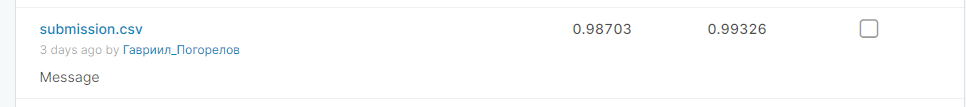

In [0]:
# Итговый сабмит
from IPython.core.display import Image, display
display(Image('/content/resnet.PNG', width=1000, unconfined=True))